In [7]:
### Prepare module structure ###

import sys
sys.path.append("../")

In [8]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
import data
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.0.0


In [9]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


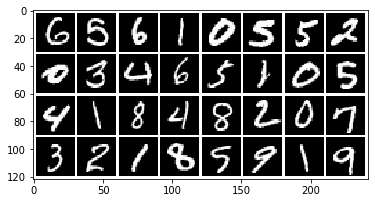

torch.Size([32, 1, 28, 28])


In [10]:
### LOAD DATA ###

dataset = 'mnist'
dataloader, imsize = data.load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft ** 2, -1))

plot_grid(sample)
print(sample_magnitudes.shape)

In [11]:
def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    return mags

In [12]:
# Define Gen and Disc loss
def gen_loss(disc_gen, gen_output, x, lmd):
    reconstruction = torch.mean(torch.abs(x - gen_output))
    adversarial = -torch.mean(torch.log(disc_gen))
    return  adversarial + lmd * reconstruction

def disc_loss(disc_real, disc_gen):
    return -torch.mean((torch.log(disc_real) + torch.log(1 - disc_gen)) / 2.0)

In [13]:
### Create new models ###

gen = models.FCNet(imsize=(2, 28, 28), outsize=imsize, h=2048)
#gen = models.ConvNet(imsize=(2, 28, 28), outsize=imsize, s=64)
#disc = models.FCDiscriminator(imsize=imsize, h=2048)
disc = models.ConvDiscriminatorSmall(imsize=(2, 28, 28), s=64)

Version 0.4


In [14]:
# Set training parameters

lmd = 1e3 # loss signal

g_opt = optim.Adam(gen.parameters(), lr=1e-4)
d_opt = optim.Adam(disc.parameters(), lr=1e-4)

In [15]:
# Initial loss

gen = gen.to(device)
disc = disc.to(device)
sample = sample.to(device)
sample_magnitudes = sample_magnitudes.to(device)

zm = torch.cat([torch.randn(*sample.shape).to(device), sample_magnitudes], dim=1)
gen_out = gen(zm)

xm = torch.cat([sample, sample_magnitudes], dim=1)
disc_output_real = disc(xm)
disc_output_generated = disc(torch.cat([gen_out, sample_magnitudes], dim=1))

g_loss = gen_loss(disc_output_generated, gen_out, sample, lmd)
d_loss = disc_loss(disc_output_real, disc_output_generated)

print("Generator loss:", g_loss.item())
print("Discriminator initial loss:", d_loss.item())

Generator loss: 473.94537353515625
Discriminator initial loss: 0.729948878288269


In [16]:
def train_model(gen, disc, g_opt, d_opt, device, loader_train, epochs=1):
    """
    Train a the conditional gan
    
    Returns: Loss history per iteration step
    """
    
    # move the model parameters to CPU/GPU
    disc = disc.to(device=device)
    gen = gen.to(device=device)
    
    # loss history
    history_g = []
    history_d = []
    history_mse = []
    
    for e in range(epochs):
        for t, x in enumerate(loader_train):
            # move x to device and reduce to magnitude information in fourier space
            x = x.to(device=device)
            magnitudes = calc_mags(x)
            
            # stack magnitudes to noise / generator input
            z = torch.randn(*x.shape).to(device)
            #z = torch.zeros(*x.shape).to(device)
            #z = magnitudes.clone()
            
            zm = torch.cat([z, magnitudes], dim=1)
            
            # calc gen output
            gen.train()
            gen_output = gen(zm)
            
            # calc disc output for real and generated image
            xm = torch.cat([x, magnitudes], dim=1)
            disc.train()
            disc_output_real = disc(xm)
            disc_output_generated = disc(torch.cat([gen_output, magnitudes], dim=1))
            
            # calculate generator loss and update generator
            g_loss = gen_loss(disc_output_generated, gen_output, x, lmd)
            history_g.append(g_loss.item())
            g_opt.zero_grad()
            g_loss.backward(retain_graph=True)
            #torch.nn.utils.clip_grad_value_(gen.parameters(), 1e-1)
            g_opt.step()
           
            # calculate discriminator loss and update discriminator
            d_loss = disc_loss(disc_output_real, disc_output_generated)
            history_d.append(d_loss.item())
            d_opt.zero_grad()
            d_loss.backward()
            #torch.nn.utils.clip_grad_value_(disc.parameters(), 1e-1)
            d_opt.step()
            
            mse_loss = torch.mean((x - gen_output) ** 2)
            history_mse.append(mse_loss.detach().cpu().item())

            if t % 100 == 0:
                print("epoch: {:2} \t step:{} \t loss: {:3.4}".format(e+1, t, history_g[-1]))
            
        plt.plot(history_g[-10000:], label="Gen loss")
        plt.plot(history_d[-10000:], label="Disc loss")
        plt.plot(history_mse[-10000:], label="MSE")
        plt.legend()
        plt.show()
        
    return history_mse

In [17]:
model_name = "randz"

epoch:  1 	 step:0 	 loss: 473.2
epoch:  1 	 step:100 	 loss: 130.2
epoch:  1 	 step:200 	 loss: 107.6
epoch:  1 	 step:300 	 loss: 112.4
epoch:  1 	 step:400 	 loss: 93.21
epoch:  1 	 step:500 	 loss: 82.46
epoch:  1 	 step:600 	 loss: 80.68
epoch:  1 	 step:700 	 loss: 77.4
epoch:  1 	 step:800 	 loss: 87.02
epoch:  1 	 step:900 	 loss: 82.41
epoch:  1 	 step:1000 	 loss: 80.71
epoch:  1 	 step:1100 	 loss: 79.87
epoch:  1 	 step:1200 	 loss: 77.3
epoch:  1 	 step:1300 	 loss: 83.77
epoch:  1 	 step:1400 	 loss: 63.83
epoch:  1 	 step:1500 	 loss: 71.7
epoch:  1 	 step:1600 	 loss: 77.77
epoch:  1 	 step:1700 	 loss: 69.75
epoch:  1 	 step:1800 	 loss: 70.1


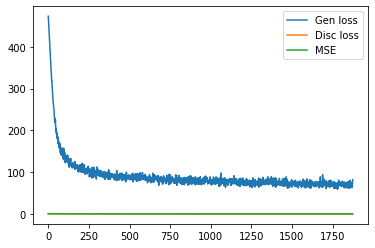

epoch:  2 	 step:0 	 loss: 60.97
epoch:  2 	 step:100 	 loss: 69.59
epoch:  2 	 step:200 	 loss: 75.21
epoch:  2 	 step:300 	 loss: 69.81
epoch:  2 	 step:400 	 loss: 70.92
epoch:  2 	 step:500 	 loss: 62.98
epoch:  2 	 step:600 	 loss: 70.5
epoch:  2 	 step:700 	 loss: 64.71
epoch:  2 	 step:800 	 loss: 70.94
epoch:  2 	 step:900 	 loss: 77.93
epoch:  2 	 step:1000 	 loss: 66.41
epoch:  2 	 step:1100 	 loss: 60.48
epoch:  2 	 step:1200 	 loss: 70.09
epoch:  2 	 step:1300 	 loss: 58.2
epoch:  2 	 step:1400 	 loss: 69.04
epoch:  2 	 step:1500 	 loss: 57.99
epoch:  2 	 step:1600 	 loss: 69.34
epoch:  2 	 step:1700 	 loss: 61.68
epoch:  2 	 step:1800 	 loss: 68.76


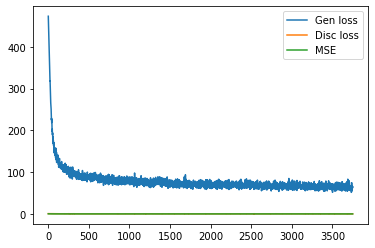

epoch:  3 	 step:0 	 loss: 66.08
epoch:  3 	 step:100 	 loss: 61.84
epoch:  3 	 step:200 	 loss: 62.74
epoch:  3 	 step:300 	 loss: 62.66
epoch:  3 	 step:400 	 loss: 63.54
epoch:  3 	 step:500 	 loss: 61.28
epoch:  3 	 step:600 	 loss: 66.21
epoch:  3 	 step:700 	 loss: 55.15
epoch:  3 	 step:800 	 loss: 62.18
epoch:  3 	 step:900 	 loss: 64.91
epoch:  3 	 step:1000 	 loss: 59.06
epoch:  3 	 step:1100 	 loss: 61.81
epoch:  3 	 step:1200 	 loss: 65.73
epoch:  3 	 step:1300 	 loss: 57.99
epoch:  3 	 step:1400 	 loss: 65.58
epoch:  3 	 step:1500 	 loss: 63.03
epoch:  3 	 step:1600 	 loss: 58.85
epoch:  3 	 step:1700 	 loss: 57.85
epoch:  3 	 step:1800 	 loss: 53.8


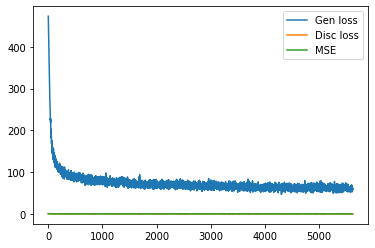

epoch:  4 	 step:0 	 loss: 58.76
epoch:  4 	 step:100 	 loss: 57.29
epoch:  4 	 step:200 	 loss: 62.11
epoch:  4 	 step:300 	 loss: 62.7
epoch:  4 	 step:400 	 loss: 57.89
epoch:  4 	 step:500 	 loss: 70.78
epoch:  4 	 step:600 	 loss: 56.96
epoch:  4 	 step:700 	 loss: 63.8
epoch:  4 	 step:800 	 loss: 68.37
epoch:  4 	 step:900 	 loss: 63.06
epoch:  4 	 step:1000 	 loss: 59.72
epoch:  4 	 step:1100 	 loss: 58.48
epoch:  4 	 step:1200 	 loss: 51.45
epoch:  4 	 step:1300 	 loss: 54.51
epoch:  4 	 step:1400 	 loss: 61.47
epoch:  4 	 step:1500 	 loss: 58.61
epoch:  4 	 step:1600 	 loss: 56.77
epoch:  4 	 step:1700 	 loss: 60.38
epoch:  4 	 step:1800 	 loss: 64.86


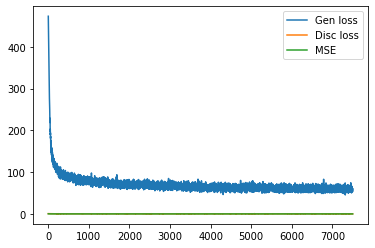

epoch:  5 	 step:0 	 loss: 57.8
epoch:  5 	 step:100 	 loss: 51.98
epoch:  5 	 step:200 	 loss: 47.78
epoch:  5 	 step:300 	 loss: 56.82
epoch:  5 	 step:400 	 loss: 63.43
epoch:  5 	 step:500 	 loss: 54.92
epoch:  5 	 step:600 	 loss: 57.27
epoch:  5 	 step:700 	 loss: 63.11
epoch:  5 	 step:800 	 loss: 61.29
epoch:  5 	 step:900 	 loss: 57.04
epoch:  5 	 step:1000 	 loss: 57.01
epoch:  5 	 step:1100 	 loss: 56.14
epoch:  5 	 step:1200 	 loss: 57.38
epoch:  5 	 step:1300 	 loss: 59.86
epoch:  5 	 step:1400 	 loss: 58.86
epoch:  5 	 step:1500 	 loss: 50.95
epoch:  5 	 step:1600 	 loss: 67.91
epoch:  5 	 step:1700 	 loss: 56.93
epoch:  5 	 step:1800 	 loss: 54.66


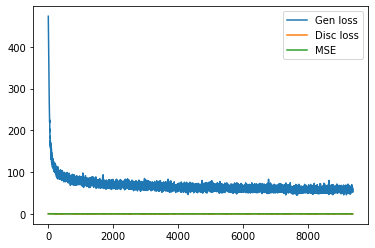

epoch:  6 	 step:0 	 loss: 60.1
epoch:  6 	 step:100 	 loss: 57.38
epoch:  6 	 step:200 	 loss: 58.94
epoch:  6 	 step:300 	 loss: 58.59
epoch:  6 	 step:400 	 loss: 59.27
epoch:  6 	 step:500 	 loss: 55.24
epoch:  6 	 step:600 	 loss: 61.72
epoch:  6 	 step:700 	 loss: 54.01
epoch:  6 	 step:800 	 loss: 61.3
epoch:  6 	 step:900 	 loss: 59.02
epoch:  6 	 step:1000 	 loss: 49.45
epoch:  6 	 step:1100 	 loss: 53.57
epoch:  6 	 step:1200 	 loss: 57.88
epoch:  6 	 step:1300 	 loss: 48.65
epoch:  6 	 step:1400 	 loss: 62.12
epoch:  6 	 step:1500 	 loss: 58.09
epoch:  6 	 step:1600 	 loss: 55.96
epoch:  6 	 step:1700 	 loss: 50.96
epoch:  6 	 step:1800 	 loss: 54.84


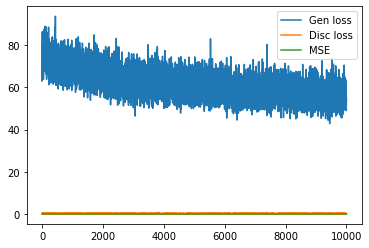

epoch:  7 	 step:0 	 loss: 55.91
epoch:  7 	 step:100 	 loss: 52.14
epoch:  7 	 step:200 	 loss: 49.8
epoch:  7 	 step:300 	 loss: 54.54
epoch:  7 	 step:400 	 loss: 53.26
epoch:  7 	 step:500 	 loss: 62.37
epoch:  7 	 step:600 	 loss: 56.29
epoch:  7 	 step:700 	 loss: 51.1
epoch:  7 	 step:800 	 loss: 52.3
epoch:  7 	 step:900 	 loss: 64.36
epoch:  7 	 step:1000 	 loss: 53.54
epoch:  7 	 step:1100 	 loss: 55.73
epoch:  7 	 step:1200 	 loss: 51.85
epoch:  7 	 step:1300 	 loss: 49.5
epoch:  7 	 step:1400 	 loss: 55.34
epoch:  7 	 step:1500 	 loss: 57.63
epoch:  7 	 step:1600 	 loss: 54.6
epoch:  7 	 step:1700 	 loss: 58.25
epoch:  7 	 step:1800 	 loss: 49.38


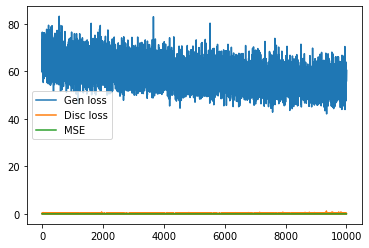

epoch:  8 	 step:0 	 loss: 53.7
epoch:  8 	 step:100 	 loss: 49.58
epoch:  8 	 step:200 	 loss: 50.47
epoch:  8 	 step:300 	 loss: 51.38
epoch:  8 	 step:400 	 loss: 52.6
epoch:  8 	 step:500 	 loss: 57.3
epoch:  8 	 step:600 	 loss: 51.11
epoch:  8 	 step:700 	 loss: 48.07
epoch:  8 	 step:800 	 loss: 54.7
epoch:  8 	 step:900 	 loss: 50.9
epoch:  8 	 step:1000 	 loss: 55.15
epoch:  8 	 step:1100 	 loss: 49.51
epoch:  8 	 step:1200 	 loss: 63.53
epoch:  8 	 step:1300 	 loss: 47.2
epoch:  8 	 step:1400 	 loss: 53.31
epoch:  8 	 step:1500 	 loss: 50.22
epoch:  8 	 step:1600 	 loss: 58.82
epoch:  8 	 step:1700 	 loss: 54.52
epoch:  8 	 step:1800 	 loss: 49.74


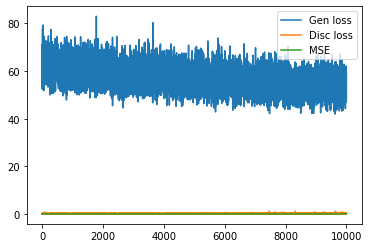

epoch:  9 	 step:0 	 loss: 50.54
epoch:  9 	 step:100 	 loss: 47.71
epoch:  9 	 step:200 	 loss: 55.3
epoch:  9 	 step:300 	 loss: 50.24
epoch:  9 	 step:400 	 loss: 48.06
epoch:  9 	 step:500 	 loss: 44.21
epoch:  9 	 step:600 	 loss: 50.21
epoch:  9 	 step:700 	 loss: 53.16
epoch:  9 	 step:800 	 loss: 44.55
epoch:  9 	 step:900 	 loss: 58.49
epoch:  9 	 step:1000 	 loss: 49.99
epoch:  9 	 step:1100 	 loss: 47.01
epoch:  9 	 step:1200 	 loss: 49.19
epoch:  9 	 step:1300 	 loss: 56.81
epoch:  9 	 step:1400 	 loss: 44.03
epoch:  9 	 step:1500 	 loss: 51.55
epoch:  9 	 step:1600 	 loss: 47.68
epoch:  9 	 step:1700 	 loss: 51.78
epoch:  9 	 step:1800 	 loss: 51.23


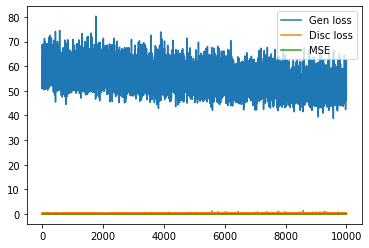

epoch: 10 	 step:0 	 loss: 52.07
epoch: 10 	 step:100 	 loss: 58.37
epoch: 10 	 step:200 	 loss: 49.94
epoch: 10 	 step:300 	 loss: 50.26
epoch: 10 	 step:400 	 loss: 48.35
epoch: 10 	 step:500 	 loss: 48.96
epoch: 10 	 step:600 	 loss: 53.62
epoch: 10 	 step:700 	 loss: 50.46
epoch: 10 	 step:800 	 loss: 50.99
epoch: 10 	 step:900 	 loss: 49.14
epoch: 10 	 step:1000 	 loss: 50.43
epoch: 10 	 step:1100 	 loss: 51.46
epoch: 10 	 step:1200 	 loss: 45.22
epoch: 10 	 step:1300 	 loss: 43.81
epoch: 10 	 step:1400 	 loss: 49.21
epoch: 10 	 step:1500 	 loss: 53.08
epoch: 10 	 step:1600 	 loss: 43.54
epoch: 10 	 step:1700 	 loss: 49.16
epoch: 10 	 step:1800 	 loss: 54.51


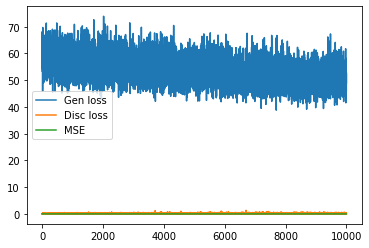

epoch: 11 	 step:0 	 loss: 48.07
epoch: 11 	 step:100 	 loss: 43.29
epoch: 11 	 step:200 	 loss: 47.24
epoch: 11 	 step:300 	 loss: 49.66
epoch: 11 	 step:400 	 loss: 45.98
epoch: 11 	 step:500 	 loss: 47.16
epoch: 11 	 step:600 	 loss: 44.18
epoch: 11 	 step:700 	 loss: 50.73
epoch: 11 	 step:800 	 loss: 48.96
epoch: 11 	 step:900 	 loss: 41.98
epoch: 11 	 step:1000 	 loss: 46.96
epoch: 11 	 step:1100 	 loss: 53.13
epoch: 11 	 step:1200 	 loss: 45.83
epoch: 11 	 step:1300 	 loss: 49.94
epoch: 11 	 step:1400 	 loss: 50.19
epoch: 11 	 step:1500 	 loss: 45.97
epoch: 11 	 step:1600 	 loss: 47.77
epoch: 11 	 step:1700 	 loss: 43.87
epoch: 11 	 step:1800 	 loss: 48.85


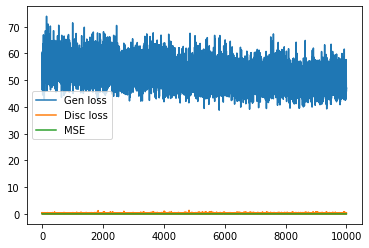

epoch: 12 	 step:0 	 loss: 49.41
epoch: 12 	 step:100 	 loss: 41.68
epoch: 12 	 step:200 	 loss: 46.1
epoch: 12 	 step:300 	 loss: 49.04
epoch: 12 	 step:400 	 loss: 49.13
epoch: 12 	 step:500 	 loss: 48.97
epoch: 12 	 step:600 	 loss: 49.3
epoch: 12 	 step:700 	 loss: 44.99
epoch: 12 	 step:800 	 loss: 46.83
epoch: 12 	 step:900 	 loss: 46.62
epoch: 12 	 step:1000 	 loss: 50.64
epoch: 12 	 step:1100 	 loss: 44.0
epoch: 12 	 step:1200 	 loss: 49.47
epoch: 12 	 step:1300 	 loss: 45.23
epoch: 12 	 step:1400 	 loss: 46.24
epoch: 12 	 step:1500 	 loss: 52.88
epoch: 12 	 step:1600 	 loss: 44.7
epoch: 12 	 step:1700 	 loss: 55.58
epoch: 12 	 step:1800 	 loss: 45.9


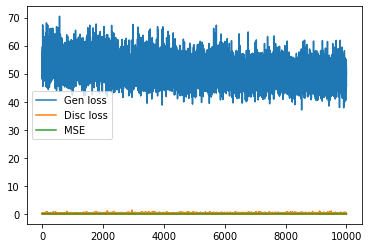

epoch: 13 	 step:0 	 loss: 48.72
epoch: 13 	 step:100 	 loss: 49.35
epoch: 13 	 step:200 	 loss: 45.86
epoch: 13 	 step:300 	 loss: 47.65
epoch: 13 	 step:400 	 loss: 49.18
epoch: 13 	 step:500 	 loss: 50.85
epoch: 13 	 step:600 	 loss: 52.9
epoch: 13 	 step:700 	 loss: 46.24
epoch: 13 	 step:800 	 loss: 45.49
epoch: 13 	 step:900 	 loss: 43.72
epoch: 13 	 step:1000 	 loss: 50.28
epoch: 13 	 step:1100 	 loss: 56.5
epoch: 13 	 step:1200 	 loss: 42.71
epoch: 13 	 step:1300 	 loss: 52.8
epoch: 13 	 step:1400 	 loss: 48.1
epoch: 13 	 step:1500 	 loss: 50.63
epoch: 13 	 step:1600 	 loss: 50.91
epoch: 13 	 step:1700 	 loss: 49.19
epoch: 13 	 step:1800 	 loss: 48.93


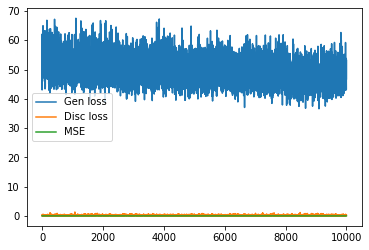

epoch: 14 	 step:0 	 loss: 51.08
epoch: 14 	 step:100 	 loss: 44.9
epoch: 14 	 step:200 	 loss: 45.22
epoch: 14 	 step:300 	 loss: 49.3
epoch: 14 	 step:400 	 loss: 49.33
epoch: 14 	 step:500 	 loss: 51.73
epoch: 14 	 step:600 	 loss: 54.37
epoch: 14 	 step:700 	 loss: 43.58
epoch: 14 	 step:800 	 loss: 45.17
epoch: 14 	 step:900 	 loss: 45.96
epoch: 14 	 step:1000 	 loss: 51.65
epoch: 14 	 step:1100 	 loss: 49.25
epoch: 14 	 step:1200 	 loss: 48.81
epoch: 14 	 step:1300 	 loss: 41.22
epoch: 14 	 step:1400 	 loss: 50.04
epoch: 14 	 step:1500 	 loss: 47.82
epoch: 14 	 step:1600 	 loss: 48.47
epoch: 14 	 step:1700 	 loss: 45.5
epoch: 14 	 step:1800 	 loss: 44.3


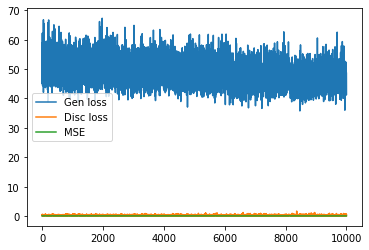

epoch: 15 	 step:0 	 loss: 47.42
epoch: 15 	 step:100 	 loss: 41.39
epoch: 15 	 step:200 	 loss: 49.31
epoch: 15 	 step:300 	 loss: 48.17
epoch: 15 	 step:400 	 loss: 50.17
epoch: 15 	 step:500 	 loss: 46.2
epoch: 15 	 step:600 	 loss: 45.45
epoch: 15 	 step:700 	 loss: 44.22
epoch: 15 	 step:800 	 loss: 44.3
epoch: 15 	 step:900 	 loss: 49.68
epoch: 15 	 step:1000 	 loss: 41.25
epoch: 15 	 step:1100 	 loss: 43.67
epoch: 15 	 step:1200 	 loss: 44.43
epoch: 15 	 step:1300 	 loss: 41.2
epoch: 15 	 step:1400 	 loss: 44.8
epoch: 15 	 step:1500 	 loss: 41.55
epoch: 15 	 step:1600 	 loss: 42.87
epoch: 15 	 step:1700 	 loss: 47.33
epoch: 15 	 step:1800 	 loss: 47.56


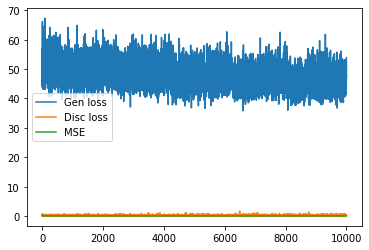

epoch: 16 	 step:0 	 loss: 43.6
epoch: 16 	 step:100 	 loss: 43.25
epoch: 16 	 step:200 	 loss: 44.61
epoch: 16 	 step:300 	 loss: 40.85
epoch: 16 	 step:400 	 loss: 42.77
epoch: 16 	 step:500 	 loss: 45.41
epoch: 16 	 step:600 	 loss: 40.1
epoch: 16 	 step:700 	 loss: 42.97
epoch: 16 	 step:800 	 loss: 40.3
epoch: 16 	 step:900 	 loss: 41.34
epoch: 16 	 step:1000 	 loss: 46.19
epoch: 16 	 step:1100 	 loss: 46.5
epoch: 16 	 step:1200 	 loss: 44.74
epoch: 16 	 step:1300 	 loss: 40.11
epoch: 16 	 step:1400 	 loss: 44.53
epoch: 16 	 step:1500 	 loss: 41.94
epoch: 16 	 step:1600 	 loss: 41.82
epoch: 16 	 step:1700 	 loss: 43.13
epoch: 16 	 step:1800 	 loss: 47.31


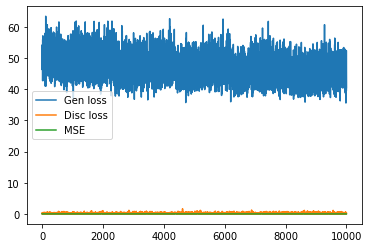

epoch: 17 	 step:0 	 loss: 47.46
epoch: 17 	 step:100 	 loss: 41.99
epoch: 17 	 step:200 	 loss: 42.03
epoch: 17 	 step:300 	 loss: 39.69
epoch: 17 	 step:400 	 loss: 41.57
epoch: 17 	 step:500 	 loss: 37.96
epoch: 17 	 step:600 	 loss: 41.36
epoch: 17 	 step:700 	 loss: 40.69
epoch: 17 	 step:800 	 loss: 39.48
epoch: 17 	 step:900 	 loss: 48.56
epoch: 17 	 step:1000 	 loss: 46.2
epoch: 17 	 step:1100 	 loss: 44.86
epoch: 17 	 step:1200 	 loss: 41.79
epoch: 17 	 step:1300 	 loss: 47.41
epoch: 17 	 step:1400 	 loss: 44.76
epoch: 17 	 step:1500 	 loss: 47.13
epoch: 17 	 step:1600 	 loss: 49.73
epoch: 17 	 step:1700 	 loss: 40.14
epoch: 17 	 step:1800 	 loss: 41.25


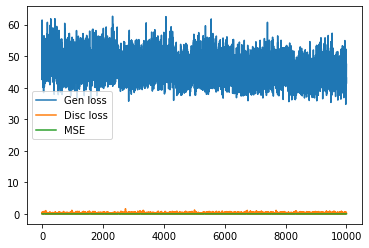

epoch: 18 	 step:0 	 loss: 42.7
epoch: 18 	 step:100 	 loss: 43.18
epoch: 18 	 step:200 	 loss: 41.69
epoch: 18 	 step:300 	 loss: 44.88
epoch: 18 	 step:400 	 loss: 38.6
epoch: 18 	 step:500 	 loss: 44.98
epoch: 18 	 step:600 	 loss: 41.13
epoch: 18 	 step:700 	 loss: 45.25
epoch: 18 	 step:800 	 loss: 42.75
epoch: 18 	 step:900 	 loss: 43.09
epoch: 18 	 step:1000 	 loss: 47.96
epoch: 18 	 step:1100 	 loss: 46.64
epoch: 18 	 step:1200 	 loss: 45.38
epoch: 18 	 step:1300 	 loss: 46.77
epoch: 18 	 step:1400 	 loss: 43.98
epoch: 18 	 step:1500 	 loss: 39.62
epoch: 18 	 step:1600 	 loss: 40.86
epoch: 18 	 step:1700 	 loss: 39.28
epoch: 18 	 step:1800 	 loss: 38.74


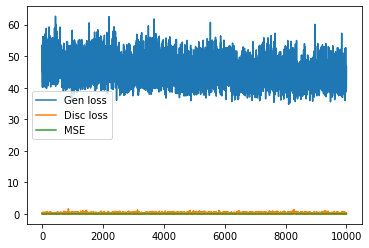

epoch: 19 	 step:0 	 loss: 43.88
epoch: 19 	 step:100 	 loss: 37.66
epoch: 19 	 step:200 	 loss: 40.91
epoch: 19 	 step:300 	 loss: 46.19
epoch: 19 	 step:400 	 loss: 41.77
epoch: 19 	 step:500 	 loss: 40.6
epoch: 19 	 step:600 	 loss: 44.9
epoch: 19 	 step:700 	 loss: 42.57
epoch: 19 	 step:800 	 loss: 42.89
epoch: 19 	 step:900 	 loss: 41.93
epoch: 19 	 step:1000 	 loss: 41.3
epoch: 19 	 step:1100 	 loss: 44.16
epoch: 19 	 step:1200 	 loss: 44.54
epoch: 19 	 step:1300 	 loss: 43.85
epoch: 19 	 step:1400 	 loss: 39.84
epoch: 19 	 step:1500 	 loss: 37.33
epoch: 19 	 step:1600 	 loss: 42.75
epoch: 19 	 step:1700 	 loss: 39.86
epoch: 19 	 step:1800 	 loss: 41.45


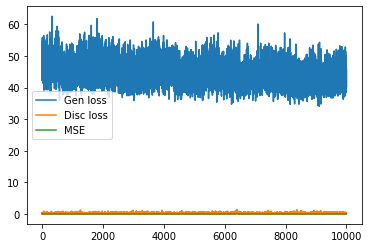

epoch: 20 	 step:0 	 loss: 46.14
epoch: 20 	 step:100 	 loss: 39.95
epoch: 20 	 step:200 	 loss: 42.03
epoch: 20 	 step:300 	 loss: 43.19
epoch: 20 	 step:400 	 loss: 37.73
epoch: 20 	 step:500 	 loss: 38.98
epoch: 20 	 step:600 	 loss: 36.63
epoch: 20 	 step:700 	 loss: 38.62
epoch: 20 	 step:800 	 loss: 42.62
epoch: 20 	 step:900 	 loss: 40.03
epoch: 20 	 step:1000 	 loss: 39.22
epoch: 20 	 step:1100 	 loss: 43.48
epoch: 20 	 step:1200 	 loss: 45.02
epoch: 20 	 step:1300 	 loss: 46.36
epoch: 20 	 step:1400 	 loss: 43.5
epoch: 20 	 step:1500 	 loss: 38.48
epoch: 20 	 step:1600 	 loss: 44.05
epoch: 20 	 step:1700 	 loss: 40.84
epoch: 20 	 step:1800 	 loss: 40.28


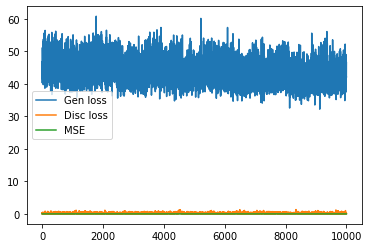

epoch: 21 	 step:0 	 loss: 40.22
epoch: 21 	 step:100 	 loss: 42.49
epoch: 21 	 step:200 	 loss: 44.59
epoch: 21 	 step:300 	 loss: 40.71
epoch: 21 	 step:400 	 loss: 41.31
epoch: 21 	 step:500 	 loss: 40.11
epoch: 21 	 step:600 	 loss: 39.84
epoch: 21 	 step:700 	 loss: 37.01
epoch: 21 	 step:800 	 loss: 37.03
epoch: 21 	 step:900 	 loss: 37.62
epoch: 21 	 step:1000 	 loss: 38.8
epoch: 21 	 step:1100 	 loss: 38.7
epoch: 21 	 step:1200 	 loss: 46.26
epoch: 21 	 step:1300 	 loss: 42.0
epoch: 21 	 step:1400 	 loss: 39.41
epoch: 21 	 step:1500 	 loss: 43.63
epoch: 21 	 step:1600 	 loss: 43.78
epoch: 21 	 step:1700 	 loss: 38.14
epoch: 21 	 step:1800 	 loss: 39.09


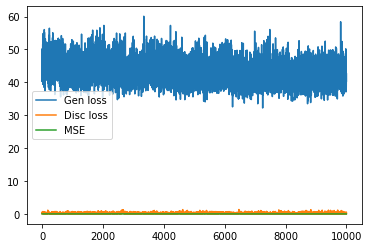

epoch: 22 	 step:0 	 loss: 36.68
epoch: 22 	 step:100 	 loss: 39.45
epoch: 22 	 step:200 	 loss: 40.63
epoch: 22 	 step:300 	 loss: 37.74
epoch: 22 	 step:400 	 loss: 48.88
epoch: 22 	 step:500 	 loss: 40.98
epoch: 22 	 step:600 	 loss: 37.61
epoch: 22 	 step:700 	 loss: 42.18
epoch: 22 	 step:800 	 loss: 39.19
epoch: 22 	 step:900 	 loss: 40.34
epoch: 22 	 step:1000 	 loss: 38.7
epoch: 22 	 step:1100 	 loss: 38.21
epoch: 22 	 step:1200 	 loss: 38.09
epoch: 22 	 step:1300 	 loss: 39.09
epoch: 22 	 step:1400 	 loss: 41.51
epoch: 22 	 step:1500 	 loss: 42.49
epoch: 22 	 step:1600 	 loss: 38.56
epoch: 22 	 step:1700 	 loss: 45.17
epoch: 22 	 step:1800 	 loss: 41.21


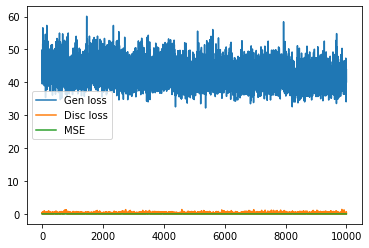

epoch: 23 	 step:0 	 loss: 43.7
epoch: 23 	 step:100 	 loss: 39.1
epoch: 23 	 step:200 	 loss: 34.4
epoch: 23 	 step:300 	 loss: 42.55
epoch: 23 	 step:400 	 loss: 44.42
epoch: 23 	 step:500 	 loss: 40.19
epoch: 23 	 step:600 	 loss: 43.48
epoch: 23 	 step:700 	 loss: 45.18
epoch: 23 	 step:800 	 loss: 46.65
epoch: 23 	 step:900 	 loss: 38.08
epoch: 23 	 step:1000 	 loss: 40.79
epoch: 23 	 step:1100 	 loss: 39.82
epoch: 23 	 step:1200 	 loss: 40.76
epoch: 23 	 step:1300 	 loss: 39.32
epoch: 23 	 step:1400 	 loss: 44.22
epoch: 23 	 step:1500 	 loss: 38.67
epoch: 23 	 step:1600 	 loss: 40.06
epoch: 23 	 step:1700 	 loss: 43.2
epoch: 23 	 step:1800 	 loss: 38.2


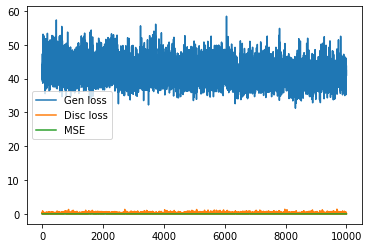

epoch: 24 	 step:0 	 loss: 37.71
epoch: 24 	 step:100 	 loss: 36.78
epoch: 24 	 step:200 	 loss: 36.2
epoch: 24 	 step:300 	 loss: 39.85
epoch: 24 	 step:400 	 loss: 43.42
epoch: 24 	 step:500 	 loss: 36.51
epoch: 24 	 step:600 	 loss: 38.24
epoch: 24 	 step:700 	 loss: 39.78
epoch: 24 	 step:800 	 loss: 34.51
epoch: 24 	 step:900 	 loss: 42.56
epoch: 24 	 step:1000 	 loss: 40.16
epoch: 24 	 step:1100 	 loss: 40.41
epoch: 24 	 step:1200 	 loss: 37.49
epoch: 24 	 step:1300 	 loss: 36.19
epoch: 24 	 step:1400 	 loss: 39.97
epoch: 24 	 step:1500 	 loss: 44.08
epoch: 24 	 step:1600 	 loss: 41.01
epoch: 24 	 step:1700 	 loss: 36.02
epoch: 24 	 step:1800 	 loss: 35.5


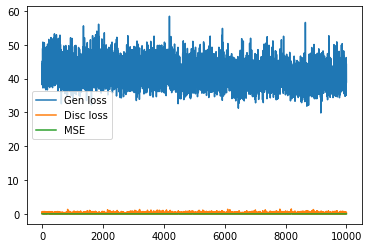

epoch: 25 	 step:0 	 loss: 40.31
epoch: 25 	 step:100 	 loss: 38.55
epoch: 25 	 step:200 	 loss: 35.77
epoch: 25 	 step:300 	 loss: 38.85
epoch: 25 	 step:400 	 loss: 34.59
epoch: 25 	 step:500 	 loss: 38.94
epoch: 25 	 step:600 	 loss: 40.17
epoch: 25 	 step:700 	 loss: 39.46
epoch: 25 	 step:800 	 loss: 35.62
epoch: 25 	 step:900 	 loss: 38.8
epoch: 25 	 step:1000 	 loss: 38.03
epoch: 25 	 step:1100 	 loss: 37.58
epoch: 25 	 step:1200 	 loss: 38.99
epoch: 25 	 step:1300 	 loss: 39.35
epoch: 25 	 step:1400 	 loss: 37.8
epoch: 25 	 step:1500 	 loss: 37.22
epoch: 25 	 step:1600 	 loss: 37.75
epoch: 25 	 step:1700 	 loss: 38.52
epoch: 25 	 step:1800 	 loss: 41.21


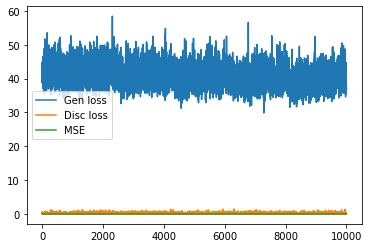

epoch: 26 	 step:0 	 loss: 38.28
epoch: 26 	 step:100 	 loss: 40.47
epoch: 26 	 step:200 	 loss: 37.83
epoch: 26 	 step:300 	 loss: 43.11
epoch: 26 	 step:400 	 loss: 38.86
epoch: 26 	 step:500 	 loss: 34.66
epoch: 26 	 step:600 	 loss: 39.58
epoch: 26 	 step:700 	 loss: 42.52
epoch: 26 	 step:800 	 loss: 34.77
epoch: 26 	 step:900 	 loss: 36.61
epoch: 26 	 step:1000 	 loss: 38.47
epoch: 26 	 step:1100 	 loss: 36.33
epoch: 26 	 step:1200 	 loss: 37.13
epoch: 26 	 step:1300 	 loss: 38.67
epoch: 26 	 step:1400 	 loss: 35.77
epoch: 26 	 step:1500 	 loss: 38.75
epoch: 26 	 step:1600 	 loss: 38.03
epoch: 26 	 step:1700 	 loss: 34.98
epoch: 26 	 step:1800 	 loss: 41.89


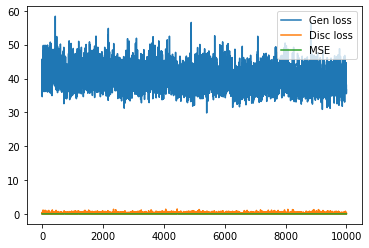

epoch: 27 	 step:0 	 loss: 42.3
epoch: 27 	 step:100 	 loss: 42.53
epoch: 27 	 step:200 	 loss: 36.8
epoch: 27 	 step:300 	 loss: 42.67
epoch: 27 	 step:400 	 loss: 37.02
epoch: 27 	 step:500 	 loss: 40.92
epoch: 27 	 step:600 	 loss: 35.04
epoch: 27 	 step:700 	 loss: 37.86
epoch: 27 	 step:800 	 loss: 40.7
epoch: 27 	 step:900 	 loss: 35.92
epoch: 27 	 step:1000 	 loss: 35.3
epoch: 27 	 step:1100 	 loss: 34.81
epoch: 27 	 step:1200 	 loss: 47.26
epoch: 27 	 step:1300 	 loss: 35.94
epoch: 27 	 step:1400 	 loss: 39.3
epoch: 27 	 step:1500 	 loss: 35.08
epoch: 27 	 step:1600 	 loss: 40.27
epoch: 27 	 step:1700 	 loss: 39.5
epoch: 27 	 step:1800 	 loss: 44.01


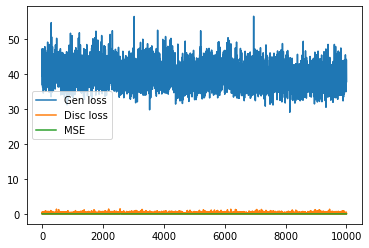

epoch: 28 	 step:0 	 loss: 36.83
epoch: 28 	 step:100 	 loss: 36.73
epoch: 28 	 step:200 	 loss: 39.88
epoch: 28 	 step:300 	 loss: 36.55
epoch: 28 	 step:400 	 loss: 32.46
epoch: 28 	 step:500 	 loss: 38.81
epoch: 28 	 step:600 	 loss: 37.36
epoch: 28 	 step:700 	 loss: 39.68
epoch: 28 	 step:800 	 loss: 35.79
epoch: 28 	 step:900 	 loss: 39.54
epoch: 28 	 step:1000 	 loss: 36.66
epoch: 28 	 step:1100 	 loss: 38.26
epoch: 28 	 step:1200 	 loss: 40.98
epoch: 28 	 step:1300 	 loss: 31.66
epoch: 28 	 step:1400 	 loss: 40.39
epoch: 28 	 step:1500 	 loss: 38.58
epoch: 28 	 step:1600 	 loss: 39.16
epoch: 28 	 step:1700 	 loss: 40.18
epoch: 28 	 step:1800 	 loss: 36.11


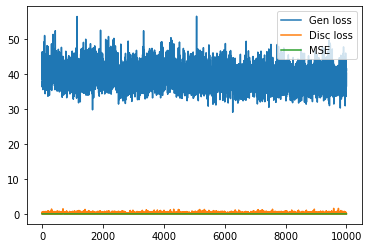

epoch: 29 	 step:0 	 loss: 37.79
epoch: 29 	 step:100 	 loss: 37.43
epoch: 29 	 step:200 	 loss: 38.83
epoch: 29 	 step:300 	 loss: 36.2
epoch: 29 	 step:400 	 loss: 36.55
epoch: 29 	 step:500 	 loss: 34.67
epoch: 29 	 step:600 	 loss: 37.5
epoch: 29 	 step:700 	 loss: 36.06
epoch: 29 	 step:800 	 loss: 38.5
epoch: 29 	 step:900 	 loss: 36.82
epoch: 29 	 step:1000 	 loss: 37.99
epoch: 29 	 step:1100 	 loss: 40.91
epoch: 29 	 step:1200 	 loss: 38.81
epoch: 29 	 step:1300 	 loss: 36.94
epoch: 29 	 step:1400 	 loss: 37.47
epoch: 29 	 step:1500 	 loss: 32.67
epoch: 29 	 step:1600 	 loss: 37.27
epoch: 29 	 step:1700 	 loss: 34.2
epoch: 29 	 step:1800 	 loss: 35.45


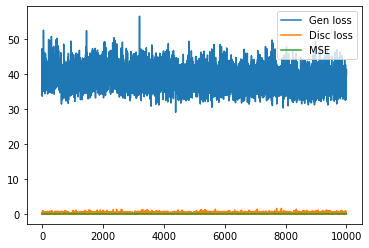

epoch: 30 	 step:0 	 loss: 38.37
epoch: 30 	 step:100 	 loss: 35.0
epoch: 30 	 step:200 	 loss: 38.56
epoch: 30 	 step:300 	 loss: 37.47
epoch: 30 	 step:400 	 loss: 37.78
epoch: 30 	 step:500 	 loss: 37.33
epoch: 30 	 step:600 	 loss: 35.94
epoch: 30 	 step:700 	 loss: 37.63
epoch: 30 	 step:800 	 loss: 38.02
epoch: 30 	 step:900 	 loss: 35.36
epoch: 30 	 step:1000 	 loss: 38.72
epoch: 30 	 step:1100 	 loss: 36.66
epoch: 30 	 step:1200 	 loss: 36.24
epoch: 30 	 step:1300 	 loss: 39.15
epoch: 30 	 step:1400 	 loss: 34.94
epoch: 30 	 step:1500 	 loss: 38.56
epoch: 30 	 step:1600 	 loss: 32.85
epoch: 30 	 step:1700 	 loss: 36.21
epoch: 30 	 step:1800 	 loss: 41.79


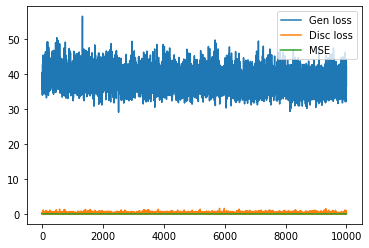

epoch: 31 	 step:0 	 loss: 35.74
epoch: 31 	 step:100 	 loss: 37.61
epoch: 31 	 step:200 	 loss: 41.92
epoch: 31 	 step:300 	 loss: 34.39
epoch: 31 	 step:400 	 loss: 33.78
epoch: 31 	 step:500 	 loss: 36.36
epoch: 31 	 step:600 	 loss: 36.62
epoch: 31 	 step:700 	 loss: 40.3
epoch: 31 	 step:800 	 loss: 36.81
epoch: 31 	 step:900 	 loss: 33.84
epoch: 31 	 step:1000 	 loss: 37.75
epoch: 31 	 step:1100 	 loss: 34.26
epoch: 31 	 step:1200 	 loss: 38.69
epoch: 31 	 step:1300 	 loss: 39.03
epoch: 31 	 step:1400 	 loss: 35.34
epoch: 31 	 step:1500 	 loss: 45.28
epoch: 31 	 step:1600 	 loss: 36.16
epoch: 31 	 step:1700 	 loss: 33.24
epoch: 31 	 step:1800 	 loss: 39.82


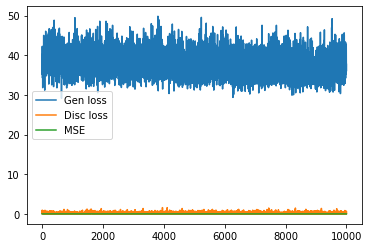

epoch: 32 	 step:0 	 loss: 38.0
epoch: 32 	 step:100 	 loss: 35.97
epoch: 32 	 step:200 	 loss: 34.81
epoch: 32 	 step:300 	 loss: 35.76
epoch: 32 	 step:400 	 loss: 36.82
epoch: 32 	 step:500 	 loss: 37.45
epoch: 32 	 step:600 	 loss: 36.52
epoch: 32 	 step:700 	 loss: 39.73
epoch: 32 	 step:800 	 loss: 31.12
epoch: 32 	 step:900 	 loss: 30.82
epoch: 32 	 step:1000 	 loss: 39.13
epoch: 32 	 step:1100 	 loss: 39.4
epoch: 32 	 step:1200 	 loss: 38.81
epoch: 32 	 step:1300 	 loss: 34.28
epoch: 32 	 step:1400 	 loss: 38.58
epoch: 32 	 step:1500 	 loss: 34.64
epoch: 32 	 step:1600 	 loss: 31.87
epoch: 32 	 step:1700 	 loss: 35.14
epoch: 32 	 step:1800 	 loss: 38.11


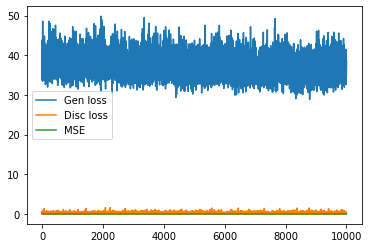

epoch: 33 	 step:0 	 loss: 34.36
epoch: 33 	 step:100 	 loss: 39.41
epoch: 33 	 step:200 	 loss: 34.23
epoch: 33 	 step:300 	 loss: 35.56
epoch: 33 	 step:400 	 loss: 34.34
epoch: 33 	 step:500 	 loss: 34.13
epoch: 33 	 step:600 	 loss: 33.45
epoch: 33 	 step:700 	 loss: 36.21
epoch: 33 	 step:800 	 loss: 34.07
epoch: 33 	 step:900 	 loss: 35.95
epoch: 33 	 step:1000 	 loss: 36.04
epoch: 33 	 step:1100 	 loss: 32.74
epoch: 33 	 step:1200 	 loss: 35.18
epoch: 33 	 step:1300 	 loss: 32.21
epoch: 33 	 step:1400 	 loss: 34.84
epoch: 33 	 step:1500 	 loss: 33.31
epoch: 33 	 step:1600 	 loss: 38.91
epoch: 33 	 step:1700 	 loss: 38.26
epoch: 33 	 step:1800 	 loss: 35.56


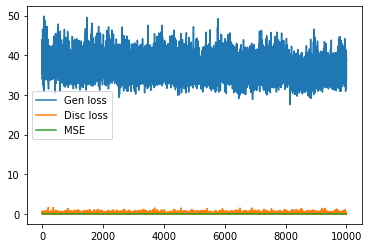

epoch: 34 	 step:0 	 loss: 40.54
epoch: 34 	 step:100 	 loss: 37.11
epoch: 34 	 step:200 	 loss: 31.43
epoch: 34 	 step:300 	 loss: 34.8
epoch: 34 	 step:400 	 loss: 35.26
epoch: 34 	 step:500 	 loss: 33.82
epoch: 34 	 step:600 	 loss: 36.67
epoch: 34 	 step:700 	 loss: 36.16
epoch: 34 	 step:800 	 loss: 33.83
epoch: 34 	 step:900 	 loss: 37.34
epoch: 34 	 step:1000 	 loss: 33.88
epoch: 34 	 step:1100 	 loss: 40.04
epoch: 34 	 step:1200 	 loss: 33.89
epoch: 34 	 step:1300 	 loss: 37.3
epoch: 34 	 step:1400 	 loss: 34.35
epoch: 34 	 step:1500 	 loss: 38.15
epoch: 34 	 step:1600 	 loss: 39.8
epoch: 34 	 step:1700 	 loss: 37.4
epoch: 34 	 step:1800 	 loss: 32.92


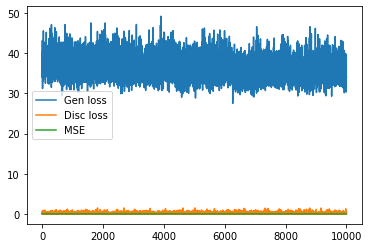

epoch: 35 	 step:0 	 loss: 33.9
epoch: 35 	 step:100 	 loss: 33.09
epoch: 35 	 step:200 	 loss: 33.97
epoch: 35 	 step:300 	 loss: 35.43
epoch: 35 	 step:400 	 loss: 32.06
epoch: 35 	 step:500 	 loss: 35.27
epoch: 35 	 step:600 	 loss: 35.22
epoch: 35 	 step:700 	 loss: 34.72
epoch: 35 	 step:800 	 loss: 38.46
epoch: 35 	 step:900 	 loss: 33.65
epoch: 35 	 step:1000 	 loss: 35.88
epoch: 35 	 step:1100 	 loss: 36.91
epoch: 35 	 step:1200 	 loss: 32.85
epoch: 35 	 step:1300 	 loss: 31.17
epoch: 35 	 step:1400 	 loss: 35.61
epoch: 35 	 step:1500 	 loss: 34.77
epoch: 35 	 step:1600 	 loss: 34.77
epoch: 35 	 step:1700 	 loss: 34.28
epoch: 35 	 step:1800 	 loss: 33.2


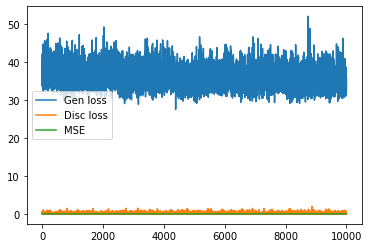

epoch: 36 	 step:0 	 loss: 29.98
epoch: 36 	 step:100 	 loss: 33.27
epoch: 36 	 step:200 	 loss: 31.05
epoch: 36 	 step:300 	 loss: 33.25
epoch: 36 	 step:400 	 loss: 36.54
epoch: 36 	 step:500 	 loss: 33.75
epoch: 36 	 step:600 	 loss: 33.05
epoch: 36 	 step:700 	 loss: 37.59
epoch: 36 	 step:800 	 loss: 35.03
epoch: 36 	 step:900 	 loss: 36.47
epoch: 36 	 step:1000 	 loss: 36.83
epoch: 36 	 step:1100 	 loss: 35.79
epoch: 36 	 step:1200 	 loss: 32.98
epoch: 36 	 step:1300 	 loss: 33.35
epoch: 36 	 step:1400 	 loss: 39.35
epoch: 36 	 step:1500 	 loss: 36.2
epoch: 36 	 step:1600 	 loss: 36.08
epoch: 36 	 step:1700 	 loss: 37.79
epoch: 36 	 step:1800 	 loss: 31.45


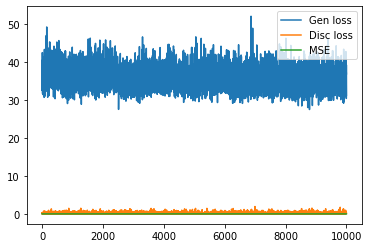

epoch: 37 	 step:0 	 loss: 34.93
epoch: 37 	 step:100 	 loss: 31.11
epoch: 37 	 step:200 	 loss: 36.74
epoch: 37 	 step:300 	 loss: 41.64
epoch: 37 	 step:400 	 loss: 29.78
epoch: 37 	 step:500 	 loss: 34.9
epoch: 37 	 step:600 	 loss: 34.72
epoch: 37 	 step:700 	 loss: 28.63
epoch: 37 	 step:800 	 loss: 32.62
epoch: 37 	 step:900 	 loss: 33.97
epoch: 37 	 step:1000 	 loss: 35.15
epoch: 37 	 step:1100 	 loss: 40.96
epoch: 37 	 step:1200 	 loss: 37.97
epoch: 37 	 step:1300 	 loss: 34.85
epoch: 37 	 step:1400 	 loss: 35.9
epoch: 37 	 step:1500 	 loss: 35.48
epoch: 37 	 step:1600 	 loss: 33.51
epoch: 37 	 step:1700 	 loss: 28.32
epoch: 37 	 step:1800 	 loss: 33.21


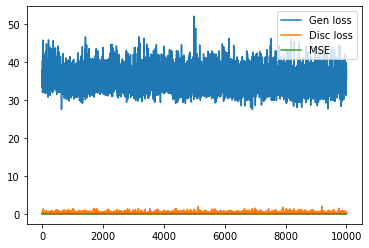

epoch: 38 	 step:0 	 loss: 34.6
epoch: 38 	 step:100 	 loss: 32.37
epoch: 38 	 step:200 	 loss: 32.5
epoch: 38 	 step:300 	 loss: 33.65
epoch: 38 	 step:400 	 loss: 28.6
epoch: 38 	 step:500 	 loss: 34.18
epoch: 38 	 step:600 	 loss: 36.66
epoch: 38 	 step:700 	 loss: 34.61
epoch: 38 	 step:800 	 loss: 33.49
epoch: 38 	 step:900 	 loss: 33.9
epoch: 38 	 step:1000 	 loss: 32.85
epoch: 38 	 step:1100 	 loss: 32.64
epoch: 38 	 step:1200 	 loss: 37.23
epoch: 38 	 step:1300 	 loss: 36.17
epoch: 38 	 step:1400 	 loss: 34.54
epoch: 38 	 step:1500 	 loss: 36.2
epoch: 38 	 step:1600 	 loss: 33.22
epoch: 38 	 step:1700 	 loss: 36.23
epoch: 38 	 step:1800 	 loss: 36.86


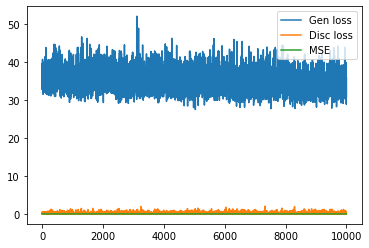

epoch: 39 	 step:0 	 loss: 32.1
epoch: 39 	 step:100 	 loss: 38.42
epoch: 39 	 step:200 	 loss: 39.18
epoch: 39 	 step:300 	 loss: 31.56
epoch: 39 	 step:400 	 loss: 33.73
epoch: 39 	 step:500 	 loss: 35.08
epoch: 39 	 step:600 	 loss: 36.49
epoch: 39 	 step:700 	 loss: 31.59
epoch: 39 	 step:800 	 loss: 36.76
epoch: 39 	 step:900 	 loss: 30.73
epoch: 39 	 step:1000 	 loss: 36.35
epoch: 39 	 step:1100 	 loss: 33.71
epoch: 39 	 step:1200 	 loss: 32.1
epoch: 39 	 step:1300 	 loss: 34.74
epoch: 39 	 step:1400 	 loss: 32.47
epoch: 39 	 step:1500 	 loss: 36.07
epoch: 39 	 step:1600 	 loss: 32.62
epoch: 39 	 step:1700 	 loss: 33.34
epoch: 39 	 step:1800 	 loss: 32.86


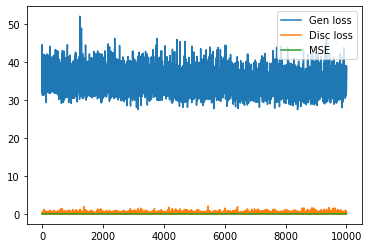

epoch: 40 	 step:0 	 loss: 40.26
epoch: 40 	 step:100 	 loss: 29.61
epoch: 40 	 step:200 	 loss: 35.07
epoch: 40 	 step:300 	 loss: 31.99
epoch: 40 	 step:400 	 loss: 33.25
epoch: 40 	 step:500 	 loss: 32.08
epoch: 40 	 step:600 	 loss: 35.36
epoch: 40 	 step:700 	 loss: 32.17
epoch: 40 	 step:800 	 loss: 37.36
epoch: 40 	 step:900 	 loss: 32.59
epoch: 40 	 step:1000 	 loss: 32.05
epoch: 40 	 step:1100 	 loss: 30.34
epoch: 40 	 step:1200 	 loss: 33.15
epoch: 40 	 step:1300 	 loss: 31.92
epoch: 40 	 step:1400 	 loss: 33.75
epoch: 40 	 step:1500 	 loss: 34.05
epoch: 40 	 step:1600 	 loss: 35.8
epoch: 40 	 step:1700 	 loss: 32.65
epoch: 40 	 step:1800 	 loss: 32.54


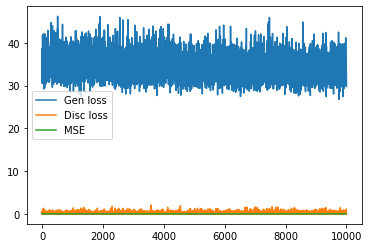

epoch: 41 	 step:0 	 loss: 34.04
epoch: 41 	 step:100 	 loss: 31.48
epoch: 41 	 step:200 	 loss: 34.32
epoch: 41 	 step:300 	 loss: 30.52
epoch: 41 	 step:400 	 loss: 30.98
epoch: 41 	 step:500 	 loss: 34.18
epoch: 41 	 step:600 	 loss: 40.02
epoch: 41 	 step:700 	 loss: 35.48
epoch: 41 	 step:800 	 loss: 32.17
epoch: 41 	 step:900 	 loss: 33.73
epoch: 41 	 step:1000 	 loss: 33.87
epoch: 41 	 step:1100 	 loss: 32.57
epoch: 41 	 step:1200 	 loss: 33.95
epoch: 41 	 step:1300 	 loss: 32.47
epoch: 41 	 step:1400 	 loss: 30.77
epoch: 41 	 step:1500 	 loss: 32.95
epoch: 41 	 step:1600 	 loss: 38.16
epoch: 41 	 step:1700 	 loss: 34.14
epoch: 41 	 step:1800 	 loss: 36.49


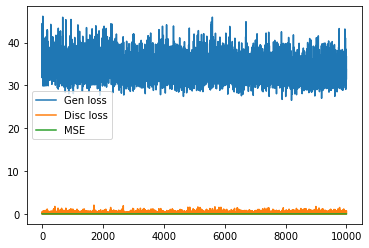

epoch: 42 	 step:0 	 loss: 35.27
epoch: 42 	 step:100 	 loss: 33.21
epoch: 42 	 step:200 	 loss: 33.04
epoch: 42 	 step:300 	 loss: 31.51
epoch: 42 	 step:400 	 loss: 31.63
epoch: 42 	 step:500 	 loss: 30.09
epoch: 42 	 step:600 	 loss: 32.78
epoch: 42 	 step:700 	 loss: 28.31
epoch: 42 	 step:800 	 loss: 30.12
epoch: 42 	 step:900 	 loss: 30.07
epoch: 42 	 step:1000 	 loss: 29.69
epoch: 42 	 step:1100 	 loss: 32.52
epoch: 42 	 step:1200 	 loss: 35.75
epoch: 42 	 step:1300 	 loss: 31.16
epoch: 42 	 step:1400 	 loss: 37.09
epoch: 42 	 step:1500 	 loss: 32.4
epoch: 42 	 step:1600 	 loss: 33.67
epoch: 42 	 step:1700 	 loss: 33.06
epoch: 42 	 step:1800 	 loss: 32.99


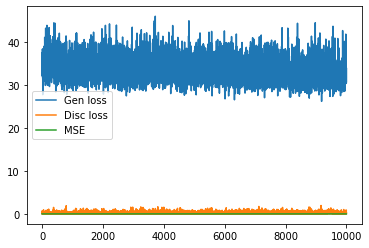

epoch: 43 	 step:0 	 loss: 32.1
epoch: 43 	 step:100 	 loss: 30.46
epoch: 43 	 step:200 	 loss: 34.24
epoch: 43 	 step:300 	 loss: 29.74
epoch: 43 	 step:400 	 loss: 32.65
epoch: 43 	 step:500 	 loss: 30.9
epoch: 43 	 step:600 	 loss: 32.28
epoch: 43 	 step:700 	 loss: 34.51
epoch: 43 	 step:800 	 loss: 32.19
epoch: 43 	 step:900 	 loss: 28.84
epoch: 43 	 step:1000 	 loss: 31.45
epoch: 43 	 step:1100 	 loss: 35.52
epoch: 43 	 step:1200 	 loss: 31.59
epoch: 43 	 step:1300 	 loss: 32.48
epoch: 43 	 step:1400 	 loss: 32.77
epoch: 43 	 step:1500 	 loss: 38.01
epoch: 43 	 step:1600 	 loss: 32.82
epoch: 43 	 step:1700 	 loss: 30.72
epoch: 43 	 step:1800 	 loss: 31.29


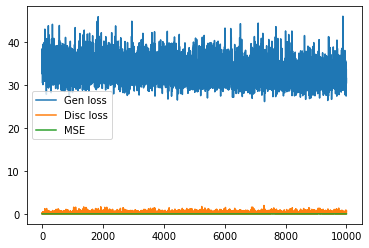

epoch: 44 	 step:0 	 loss: 33.51
epoch: 44 	 step:100 	 loss: 33.33
epoch: 44 	 step:200 	 loss: 34.16
epoch: 44 	 step:300 	 loss: 30.53
epoch: 44 	 step:400 	 loss: 34.06
epoch: 44 	 step:500 	 loss: 31.76
epoch: 44 	 step:600 	 loss: 35.32
epoch: 44 	 step:700 	 loss: 33.03
epoch: 44 	 step:800 	 loss: 32.73
epoch: 44 	 step:900 	 loss: 32.11
epoch: 44 	 step:1000 	 loss: 34.46
epoch: 44 	 step:1100 	 loss: 31.03
epoch: 44 	 step:1200 	 loss: 30.09
epoch: 44 	 step:1300 	 loss: 32.78
epoch: 44 	 step:1400 	 loss: 34.43
epoch: 44 	 step:1500 	 loss: 28.45
epoch: 44 	 step:1600 	 loss: 31.37
epoch: 44 	 step:1700 	 loss: 34.65
epoch: 44 	 step:1800 	 loss: 30.73


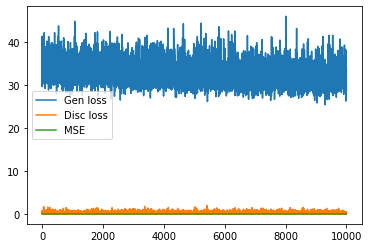

epoch: 45 	 step:0 	 loss: 31.77
epoch: 45 	 step:100 	 loss: 30.85
epoch: 45 	 step:200 	 loss: 32.76
epoch: 45 	 step:300 	 loss: 35.19
epoch: 45 	 step:400 	 loss: 30.82
epoch: 45 	 step:500 	 loss: 30.4
epoch: 45 	 step:600 	 loss: 33.9
epoch: 45 	 step:700 	 loss: 33.65
epoch: 45 	 step:800 	 loss: 31.85
epoch: 45 	 step:900 	 loss: 32.0
epoch: 45 	 step:1000 	 loss: 31.95
epoch: 45 	 step:1100 	 loss: 30.1
epoch: 45 	 step:1200 	 loss: 31.77
epoch: 45 	 step:1300 	 loss: 31.12
epoch: 45 	 step:1400 	 loss: 30.05
epoch: 45 	 step:1500 	 loss: 33.85
epoch: 45 	 step:1600 	 loss: 28.68
epoch: 45 	 step:1700 	 loss: 30.95
epoch: 45 	 step:1800 	 loss: 32.26


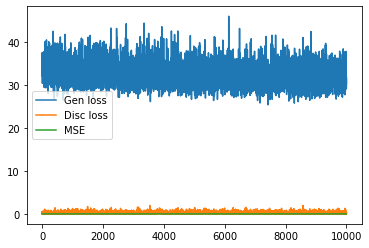

epoch: 46 	 step:0 	 loss: 30.41
epoch: 46 	 step:100 	 loss: 29.78
epoch: 46 	 step:200 	 loss: 28.87
epoch: 46 	 step:300 	 loss: 31.47
epoch: 46 	 step:400 	 loss: 33.43
epoch: 46 	 step:500 	 loss: 28.04
epoch: 46 	 step:600 	 loss: 32.64
epoch: 46 	 step:700 	 loss: 32.86
epoch: 46 	 step:800 	 loss: 32.23
epoch: 46 	 step:900 	 loss: 28.9
epoch: 46 	 step:1000 	 loss: 29.14
epoch: 46 	 step:1100 	 loss: 34.58
epoch: 46 	 step:1200 	 loss: 28.76
epoch: 46 	 step:1300 	 loss: 31.98
epoch: 46 	 step:1400 	 loss: 33.5
epoch: 46 	 step:1500 	 loss: 33.21
epoch: 46 	 step:1600 	 loss: 35.65
epoch: 46 	 step:1700 	 loss: 30.38
epoch: 46 	 step:1800 	 loss: 28.23


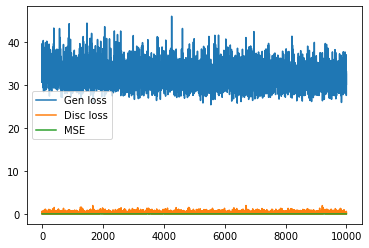

epoch: 47 	 step:0 	 loss: 28.89
epoch: 47 	 step:100 	 loss: 32.5
epoch: 47 	 step:200 	 loss: 31.89
epoch: 47 	 step:300 	 loss: 31.92
epoch: 47 	 step:400 	 loss: 29.67
epoch: 47 	 step:500 	 loss: 29.6
epoch: 47 	 step:600 	 loss: 30.85
epoch: 47 	 step:700 	 loss: 34.67
epoch: 47 	 step:800 	 loss: 30.65
epoch: 47 	 step:900 	 loss: 30.89
epoch: 47 	 step:1000 	 loss: 29.6
epoch: 47 	 step:1100 	 loss: 31.81
epoch: 47 	 step:1200 	 loss: 29.45
epoch: 47 	 step:1300 	 loss: 27.06
epoch: 47 	 step:1400 	 loss: 35.49
epoch: 47 	 step:1500 	 loss: 29.77
epoch: 47 	 step:1600 	 loss: 35.33
epoch: 47 	 step:1700 	 loss: 32.6
epoch: 47 	 step:1800 	 loss: 30.91


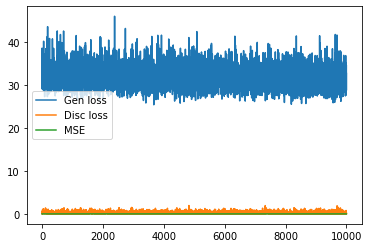

epoch: 48 	 step:0 	 loss: 31.76
epoch: 48 	 step:100 	 loss: 29.68
epoch: 48 	 step:200 	 loss: 32.66
epoch: 48 	 step:300 	 loss: 32.35
epoch: 48 	 step:400 	 loss: 30.94
epoch: 48 	 step:500 	 loss: 31.02
epoch: 48 	 step:600 	 loss: 29.2
epoch: 48 	 step:700 	 loss: 34.71
epoch: 48 	 step:800 	 loss: 29.96
epoch: 48 	 step:900 	 loss: 31.51
epoch: 48 	 step:1000 	 loss: 28.91
epoch: 48 	 step:1100 	 loss: 32.83
epoch: 48 	 step:1200 	 loss: 32.73
epoch: 48 	 step:1300 	 loss: 29.71
epoch: 48 	 step:1400 	 loss: 31.97
epoch: 48 	 step:1500 	 loss: 33.14
epoch: 48 	 step:1600 	 loss: 30.96
epoch: 48 	 step:1700 	 loss: 35.65
epoch: 48 	 step:1800 	 loss: 37.6


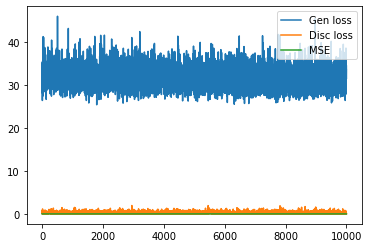

epoch: 49 	 step:0 	 loss: 30.32
epoch: 49 	 step:100 	 loss: 29.42
epoch: 49 	 step:200 	 loss: 30.9
epoch: 49 	 step:300 	 loss: 33.59
epoch: 49 	 step:400 	 loss: 29.23
epoch: 49 	 step:500 	 loss: 28.59
epoch: 49 	 step:600 	 loss: 30.06
epoch: 49 	 step:700 	 loss: 30.46
epoch: 49 	 step:800 	 loss: 31.27
epoch: 49 	 step:900 	 loss: 30.36
epoch: 49 	 step:1000 	 loss: 31.17
epoch: 49 	 step:1100 	 loss: 31.88
epoch: 49 	 step:1200 	 loss: 31.97
epoch: 49 	 step:1300 	 loss: 31.41
epoch: 49 	 step:1400 	 loss: 31.17
epoch: 49 	 step:1500 	 loss: 30.17
epoch: 49 	 step:1600 	 loss: 26.72
epoch: 49 	 step:1700 	 loss: 31.42
epoch: 49 	 step:1800 	 loss: 28.23


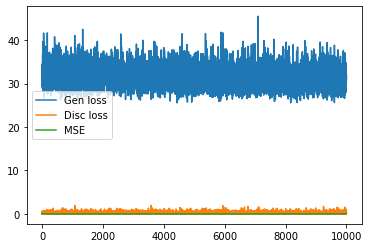

epoch: 50 	 step:0 	 loss: 31.07
epoch: 50 	 step:100 	 loss: 28.98
epoch: 50 	 step:200 	 loss: 34.54
epoch: 50 	 step:300 	 loss: 31.4
epoch: 50 	 step:400 	 loss: 30.53
epoch: 50 	 step:500 	 loss: 29.47
epoch: 50 	 step:600 	 loss: 39.32
epoch: 50 	 step:700 	 loss: 30.46
epoch: 50 	 step:800 	 loss: 33.24
epoch: 50 	 step:900 	 loss: 31.07
epoch: 50 	 step:1000 	 loss: 33.04
epoch: 50 	 step:1100 	 loss: 26.59
epoch: 50 	 step:1200 	 loss: 30.65
epoch: 50 	 step:1300 	 loss: 33.76
epoch: 50 	 step:1400 	 loss: 31.69
epoch: 50 	 step:1500 	 loss: 31.93
epoch: 50 	 step:1600 	 loss: 30.26
epoch: 50 	 step:1700 	 loss: 32.2
epoch: 50 	 step:1800 	 loss: 31.72


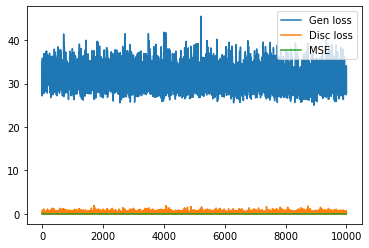

epoch: 51 	 step:0 	 loss: 28.56
epoch: 51 	 step:100 	 loss: 25.89
epoch: 51 	 step:200 	 loss: 33.22
epoch: 51 	 step:300 	 loss: 30.91
epoch: 51 	 step:400 	 loss: 28.62
epoch: 51 	 step:500 	 loss: 29.74
epoch: 51 	 step:600 	 loss: 31.0
epoch: 51 	 step:700 	 loss: 27.63
epoch: 51 	 step:800 	 loss: 30.93
epoch: 51 	 step:900 	 loss: 29.23
epoch: 51 	 step:1000 	 loss: 26.63
epoch: 51 	 step:1100 	 loss: 29.75
epoch: 51 	 step:1200 	 loss: 29.97
epoch: 51 	 step:1300 	 loss: 28.56
epoch: 51 	 step:1400 	 loss: 30.91
epoch: 51 	 step:1500 	 loss: 35.27
epoch: 51 	 step:1600 	 loss: 29.62
epoch: 51 	 step:1700 	 loss: 27.31
epoch: 51 	 step:1800 	 loss: 27.09


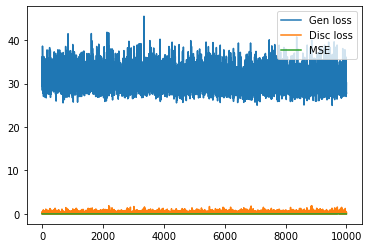

epoch: 52 	 step:0 	 loss: 30.54
epoch: 52 	 step:100 	 loss: 30.36
epoch: 52 	 step:200 	 loss: 30.08
epoch: 52 	 step:300 	 loss: 29.79
epoch: 52 	 step:400 	 loss: 31.2
epoch: 52 	 step:500 	 loss: 28.68
epoch: 52 	 step:600 	 loss: 30.18
epoch: 52 	 step:700 	 loss: 29.29
epoch: 52 	 step:800 	 loss: 28.78
epoch: 52 	 step:900 	 loss: 32.33
epoch: 52 	 step:1000 	 loss: 32.48
epoch: 52 	 step:1100 	 loss: 35.43
epoch: 52 	 step:1200 	 loss: 35.68
epoch: 52 	 step:1300 	 loss: 27.61
epoch: 52 	 step:1400 	 loss: 28.18
epoch: 52 	 step:1500 	 loss: 31.6
epoch: 52 	 step:1600 	 loss: 32.16
epoch: 52 	 step:1700 	 loss: 32.55
epoch: 52 	 step:1800 	 loss: 30.23


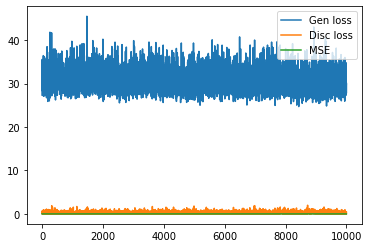

epoch: 53 	 step:0 	 loss: 28.48
epoch: 53 	 step:100 	 loss: 28.07
epoch: 53 	 step:200 	 loss: 27.02
epoch: 53 	 step:300 	 loss: 27.06
epoch: 53 	 step:400 	 loss: 30.34
epoch: 53 	 step:500 	 loss: 32.89
epoch: 53 	 step:600 	 loss: 29.59
epoch: 53 	 step:700 	 loss: 29.07
epoch: 53 	 step:800 	 loss: 29.47
epoch: 53 	 step:900 	 loss: 28.21
epoch: 53 	 step:1000 	 loss: 27.58
epoch: 53 	 step:1100 	 loss: 31.29
epoch: 53 	 step:1200 	 loss: 29.46
epoch: 53 	 step:1300 	 loss: 29.57
epoch: 53 	 step:1400 	 loss: 29.26
epoch: 53 	 step:1500 	 loss: 31.78
epoch: 53 	 step:1600 	 loss: 30.62
epoch: 53 	 step:1700 	 loss: 34.14
epoch: 53 	 step:1800 	 loss: 28.89


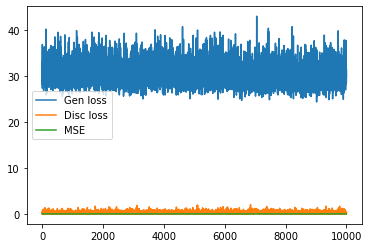

epoch: 54 	 step:0 	 loss: 28.22
epoch: 54 	 step:100 	 loss: 30.72
epoch: 54 	 step:200 	 loss: 27.9
epoch: 54 	 step:300 	 loss: 28.15
epoch: 54 	 step:400 	 loss: 30.96
epoch: 54 	 step:500 	 loss: 31.91
epoch: 54 	 step:600 	 loss: 29.84
epoch: 54 	 step:700 	 loss: 29.59
epoch: 54 	 step:800 	 loss: 31.83
epoch: 54 	 step:900 	 loss: 30.24
epoch: 54 	 step:1000 	 loss: 26.98
epoch: 54 	 step:1100 	 loss: 31.59
epoch: 54 	 step:1200 	 loss: 29.52
epoch: 54 	 step:1300 	 loss: 30.73
epoch: 54 	 step:1400 	 loss: 29.44
epoch: 54 	 step:1500 	 loss: 30.71
epoch: 54 	 step:1600 	 loss: 30.66
epoch: 54 	 step:1700 	 loss: 29.92
epoch: 54 	 step:1800 	 loss: 31.17


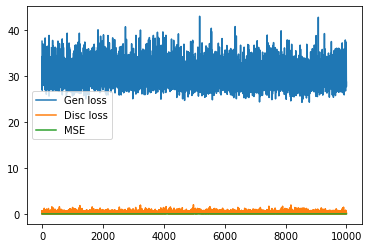

epoch: 55 	 step:0 	 loss: 26.7
epoch: 55 	 step:100 	 loss: 30.88
epoch: 55 	 step:200 	 loss: 28.47
epoch: 55 	 step:300 	 loss: 33.67
epoch: 55 	 step:400 	 loss: 27.69
epoch: 55 	 step:500 	 loss: 30.13
epoch: 55 	 step:600 	 loss: 32.84
epoch: 55 	 step:700 	 loss: 27.88
epoch: 55 	 step:800 	 loss: 30.57
epoch: 55 	 step:900 	 loss: 31.12
epoch: 55 	 step:1000 	 loss: 29.81
epoch: 55 	 step:1100 	 loss: 30.2
epoch: 55 	 step:1200 	 loss: 27.44
epoch: 55 	 step:1300 	 loss: 31.05
epoch: 55 	 step:1400 	 loss: 28.96
epoch: 55 	 step:1500 	 loss: 30.31
epoch: 55 	 step:1600 	 loss: 35.45
epoch: 55 	 step:1700 	 loss: 29.02
epoch: 55 	 step:1800 	 loss: 27.34


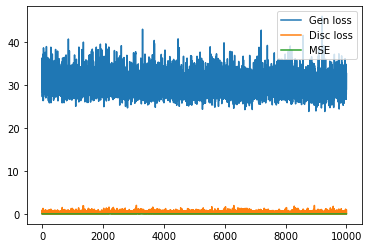

epoch: 56 	 step:0 	 loss: 25.81
epoch: 56 	 step:100 	 loss: 30.98
epoch: 56 	 step:200 	 loss: 27.59
epoch: 56 	 step:300 	 loss: 28.53
epoch: 56 	 step:400 	 loss: 31.0
epoch: 56 	 step:500 	 loss: 27.96
epoch: 56 	 step:600 	 loss: 28.77
epoch: 56 	 step:700 	 loss: 33.4
epoch: 56 	 step:800 	 loss: 27.51
epoch: 56 	 step:900 	 loss: 28.62
epoch: 56 	 step:1000 	 loss: 29.35
epoch: 56 	 step:1100 	 loss: 27.41
epoch: 56 	 step:1200 	 loss: 29.01
epoch: 56 	 step:1300 	 loss: 30.89
epoch: 56 	 step:1400 	 loss: 30.19
epoch: 56 	 step:1500 	 loss: 30.13
epoch: 56 	 step:1600 	 loss: 30.38
epoch: 56 	 step:1700 	 loss: 26.93
epoch: 56 	 step:1800 	 loss: 28.88


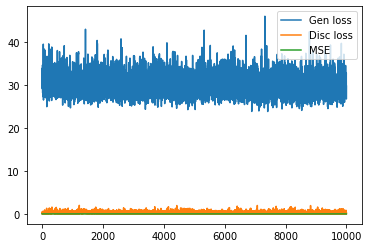

epoch: 57 	 step:0 	 loss: 34.44
epoch: 57 	 step:100 	 loss: 24.92
epoch: 57 	 step:200 	 loss: 32.03
epoch: 57 	 step:300 	 loss: 28.46
epoch: 57 	 step:400 	 loss: 29.95
epoch: 57 	 step:500 	 loss: 29.41
epoch: 57 	 step:600 	 loss: 27.49
epoch: 57 	 step:700 	 loss: 30.39
epoch: 57 	 step:800 	 loss: 27.37
epoch: 57 	 step:900 	 loss: 34.02
epoch: 57 	 step:1000 	 loss: 31.44
epoch: 57 	 step:1100 	 loss: 30.81
epoch: 57 	 step:1200 	 loss: 26.33
epoch: 57 	 step:1300 	 loss: 32.33
epoch: 57 	 step:1400 	 loss: 27.62
epoch: 57 	 step:1500 	 loss: 27.62
epoch: 57 	 step:1600 	 loss: 28.3
epoch: 57 	 step:1700 	 loss: 30.11
epoch: 57 	 step:1800 	 loss: 31.91


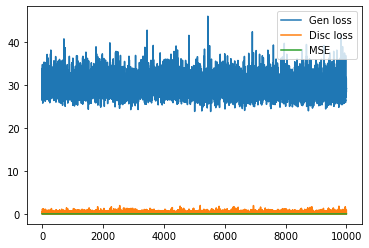

epoch: 58 	 step:0 	 loss: 27.97
epoch: 58 	 step:100 	 loss: 26.7
epoch: 58 	 step:200 	 loss: 30.2
epoch: 58 	 step:300 	 loss: 28.15
epoch: 58 	 step:400 	 loss: 29.57
epoch: 58 	 step:500 	 loss: 29.34
epoch: 58 	 step:600 	 loss: 28.32
epoch: 58 	 step:700 	 loss: 29.03
epoch: 58 	 step:800 	 loss: 30.92
epoch: 58 	 step:900 	 loss: 28.93
epoch: 58 	 step:1000 	 loss: 24.67
epoch: 58 	 step:1100 	 loss: 29.96
epoch: 58 	 step:1200 	 loss: 26.93
epoch: 58 	 step:1300 	 loss: 29.35
epoch: 58 	 step:1400 	 loss: 27.88
epoch: 58 	 step:1500 	 loss: 28.57
epoch: 58 	 step:1600 	 loss: 29.12
epoch: 58 	 step:1700 	 loss: 28.22
epoch: 58 	 step:1800 	 loss: 28.25


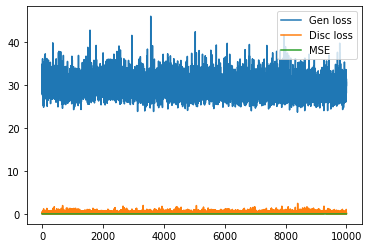

epoch: 59 	 step:0 	 loss: 29.38
epoch: 59 	 step:100 	 loss: 27.71
epoch: 59 	 step:200 	 loss: 30.51
epoch: 59 	 step:300 	 loss: 25.43
epoch: 59 	 step:400 	 loss: 29.3
epoch: 59 	 step:500 	 loss: 31.48
epoch: 59 	 step:600 	 loss: 29.03
epoch: 59 	 step:700 	 loss: 33.82
epoch: 59 	 step:800 	 loss: 29.85
epoch: 59 	 step:900 	 loss: 30.07
epoch: 59 	 step:1000 	 loss: 30.18
epoch: 59 	 step:1100 	 loss: 25.57
epoch: 59 	 step:1200 	 loss: 31.57
epoch: 59 	 step:1300 	 loss: 29.81
epoch: 59 	 step:1400 	 loss: 27.69
epoch: 59 	 step:1500 	 loss: 27.48
epoch: 59 	 step:1600 	 loss: 27.5
epoch: 59 	 step:1700 	 loss: 28.08
epoch: 59 	 step:1800 	 loss: 32.65


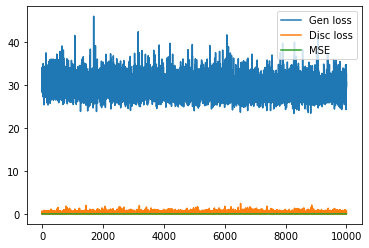

epoch: 60 	 step:0 	 loss: 27.52
epoch: 60 	 step:100 	 loss: 31.55
epoch: 60 	 step:200 	 loss: 26.64
epoch: 60 	 step:300 	 loss: 25.72
epoch: 60 	 step:400 	 loss: 29.6
epoch: 60 	 step:500 	 loss: 26.24
epoch: 60 	 step:600 	 loss: 28.61
epoch: 60 	 step:700 	 loss: 28.43
epoch: 60 	 step:800 	 loss: 31.56
epoch: 60 	 step:900 	 loss: 30.89
epoch: 60 	 step:1000 	 loss: 28.94
epoch: 60 	 step:1100 	 loss: 25.22
epoch: 60 	 step:1200 	 loss: 29.71
epoch: 60 	 step:1300 	 loss: 32.34
epoch: 60 	 step:1400 	 loss: 31.09
epoch: 60 	 step:1500 	 loss: 31.5
epoch: 60 	 step:1600 	 loss: 28.71
epoch: 60 	 step:1700 	 loss: 30.25
epoch: 60 	 step:1800 	 loss: 27.8


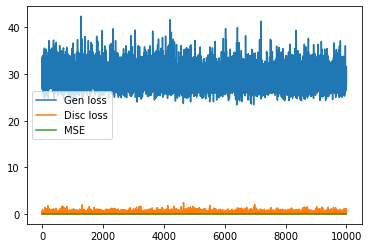

epoch: 61 	 step:0 	 loss: 25.78
epoch: 61 	 step:100 	 loss: 26.13
epoch: 61 	 step:200 	 loss: 27.67
epoch: 61 	 step:300 	 loss: 29.61
epoch: 61 	 step:400 	 loss: 32.03
epoch: 61 	 step:500 	 loss: 29.49
epoch: 61 	 step:600 	 loss: 27.35
epoch: 61 	 step:700 	 loss: 29.94
epoch: 61 	 step:800 	 loss: 27.07
epoch: 61 	 step:900 	 loss: 27.8
epoch: 61 	 step:1000 	 loss: 29.01
epoch: 61 	 step:1100 	 loss: 32.2
epoch: 61 	 step:1200 	 loss: 27.66
epoch: 61 	 step:1300 	 loss: 27.97
epoch: 61 	 step:1400 	 loss: 27.96
epoch: 61 	 step:1500 	 loss: 30.85
epoch: 61 	 step:1600 	 loss: 25.98
epoch: 61 	 step:1700 	 loss: 30.14
epoch: 61 	 step:1800 	 loss: 26.15


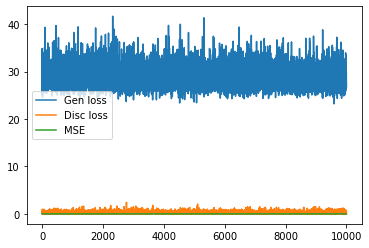

epoch: 62 	 step:0 	 loss: 29.86
epoch: 62 	 step:100 	 loss: 29.42
epoch: 62 	 step:200 	 loss: 27.66
epoch: 62 	 step:300 	 loss: 27.71
epoch: 62 	 step:400 	 loss: 31.28
epoch: 62 	 step:500 	 loss: 26.14
epoch: 62 	 step:600 	 loss: 30.43
epoch: 62 	 step:700 	 loss: 29.98
epoch: 62 	 step:800 	 loss: 29.25
epoch: 62 	 step:900 	 loss: 27.28
epoch: 62 	 step:1000 	 loss: 29.9
epoch: 62 	 step:1100 	 loss: 28.47
epoch: 62 	 step:1200 	 loss: 28.97
epoch: 62 	 step:1300 	 loss: 28.04
epoch: 62 	 step:1400 	 loss: 31.3
epoch: 62 	 step:1500 	 loss: 27.83
epoch: 62 	 step:1600 	 loss: 33.48
epoch: 62 	 step:1700 	 loss: 27.37
epoch: 62 	 step:1800 	 loss: 27.77


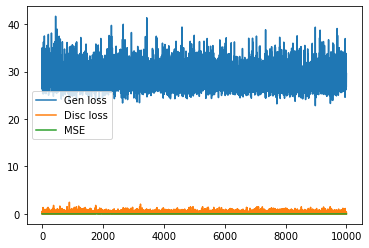

epoch: 63 	 step:0 	 loss: 26.28
epoch: 63 	 step:100 	 loss: 30.54
epoch: 63 	 step:200 	 loss: 29.85
epoch: 63 	 step:300 	 loss: 25.58
epoch: 63 	 step:400 	 loss: 28.43
epoch: 63 	 step:500 	 loss: 28.97
epoch: 63 	 step:600 	 loss: 28.28
epoch: 63 	 step:700 	 loss: 32.03
epoch: 63 	 step:800 	 loss: 31.17
epoch: 63 	 step:900 	 loss: 30.14
epoch: 63 	 step:1000 	 loss: 29.45
epoch: 63 	 step:1100 	 loss: 28.67
epoch: 63 	 step:1200 	 loss: 30.49
epoch: 63 	 step:1300 	 loss: 28.24
epoch: 63 	 step:1400 	 loss: 28.04
epoch: 63 	 step:1500 	 loss: 30.48
epoch: 63 	 step:1600 	 loss: 29.85
epoch: 63 	 step:1700 	 loss: 26.1
epoch: 63 	 step:1800 	 loss: 27.53


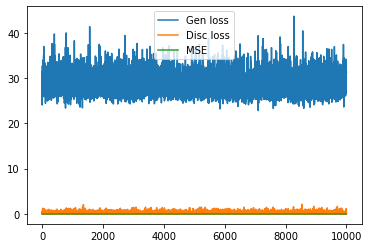

epoch: 64 	 step:0 	 loss: 28.57
epoch: 64 	 step:100 	 loss: 27.19
epoch: 64 	 step:200 	 loss: 27.52
epoch: 64 	 step:300 	 loss: 28.31
epoch: 64 	 step:400 	 loss: 23.99
epoch: 64 	 step:500 	 loss: 28.23
epoch: 64 	 step:600 	 loss: 32.66
epoch: 64 	 step:700 	 loss: 28.35
epoch: 64 	 step:800 	 loss: 29.12
epoch: 64 	 step:900 	 loss: 28.53
epoch: 64 	 step:1000 	 loss: 27.32
epoch: 64 	 step:1100 	 loss: 27.16
epoch: 64 	 step:1200 	 loss: 27.11
epoch: 64 	 step:1300 	 loss: 27.08
epoch: 64 	 step:1400 	 loss: 28.98
epoch: 64 	 step:1500 	 loss: 28.79
epoch: 64 	 step:1600 	 loss: 26.59
epoch: 64 	 step:1700 	 loss: 26.91
epoch: 64 	 step:1800 	 loss: 28.36


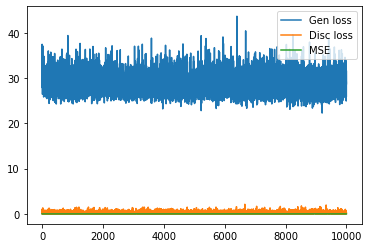

epoch: 65 	 step:0 	 loss: 28.08
epoch: 65 	 step:100 	 loss: 28.46
epoch: 65 	 step:200 	 loss: 27.35
epoch: 65 	 step:300 	 loss: 37.22
epoch: 65 	 step:400 	 loss: 27.81
epoch: 65 	 step:500 	 loss: 33.27
epoch: 65 	 step:600 	 loss: 30.13
epoch: 65 	 step:700 	 loss: 27.07
epoch: 65 	 step:800 	 loss: 28.23
epoch: 65 	 step:900 	 loss: 33.84
epoch: 65 	 step:1000 	 loss: 29.59
epoch: 65 	 step:1100 	 loss: 29.63
epoch: 65 	 step:1200 	 loss: 26.69
epoch: 65 	 step:1300 	 loss: 30.16
epoch: 65 	 step:1400 	 loss: 27.11
epoch: 65 	 step:1500 	 loss: 29.26
epoch: 65 	 step:1600 	 loss: 27.52
epoch: 65 	 step:1700 	 loss: 33.9
epoch: 65 	 step:1800 	 loss: 27.39


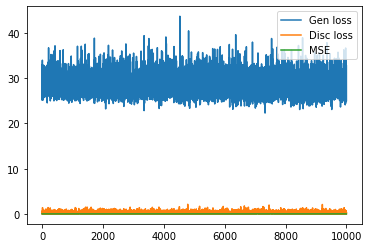

epoch: 66 	 step:0 	 loss: 29.44
epoch: 66 	 step:100 	 loss: 28.25
epoch: 66 	 step:200 	 loss: 31.89
epoch: 66 	 step:300 	 loss: 26.32
epoch: 66 	 step:400 	 loss: 26.54
epoch: 66 	 step:500 	 loss: 32.0
epoch: 66 	 step:600 	 loss: 26.88
epoch: 66 	 step:700 	 loss: 27.0
epoch: 66 	 step:800 	 loss: 30.66
epoch: 66 	 step:900 	 loss: 27.43
epoch: 66 	 step:1000 	 loss: 29.67
epoch: 66 	 step:1100 	 loss: 28.65
epoch: 66 	 step:1200 	 loss: 29.79
epoch: 66 	 step:1300 	 loss: 31.44
epoch: 66 	 step:1400 	 loss: 28.37
epoch: 66 	 step:1500 	 loss: 30.21
epoch: 66 	 step:1600 	 loss: 25.97
epoch: 66 	 step:1700 	 loss: 26.15
epoch: 66 	 step:1800 	 loss: 29.98


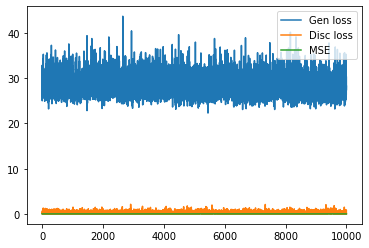

epoch: 67 	 step:0 	 loss: 27.96
epoch: 67 	 step:100 	 loss: 29.75
epoch: 67 	 step:200 	 loss: 31.4
epoch: 67 	 step:300 	 loss: 27.57
epoch: 67 	 step:400 	 loss: 31.42
epoch: 67 	 step:500 	 loss: 27.81
epoch: 67 	 step:600 	 loss: 28.03
epoch: 67 	 step:700 	 loss: 31.12
epoch: 67 	 step:800 	 loss: 27.81
epoch: 67 	 step:900 	 loss: 27.59
epoch: 67 	 step:1000 	 loss: 28.89
epoch: 67 	 step:1100 	 loss: 31.25
epoch: 67 	 step:1200 	 loss: 25.36
epoch: 67 	 step:1300 	 loss: 31.28
epoch: 67 	 step:1400 	 loss: 26.3
epoch: 67 	 step:1500 	 loss: 32.54
epoch: 67 	 step:1600 	 loss: 28.37
epoch: 67 	 step:1700 	 loss: 29.42
epoch: 67 	 step:1800 	 loss: 29.29


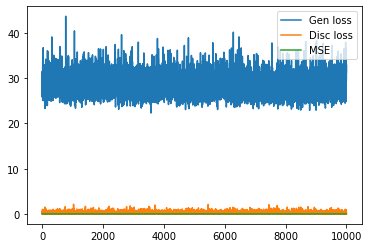

epoch: 68 	 step:0 	 loss: 28.99
epoch: 68 	 step:100 	 loss: 30.2
epoch: 68 	 step:200 	 loss: 27.37
epoch: 68 	 step:300 	 loss: 27.11
epoch: 68 	 step:400 	 loss: 29.15
epoch: 68 	 step:500 	 loss: 25.66
epoch: 68 	 step:600 	 loss: 28.45
epoch: 68 	 step:700 	 loss: 25.12
epoch: 68 	 step:800 	 loss: 26.82
epoch: 68 	 step:900 	 loss: 26.7
epoch: 68 	 step:1000 	 loss: 26.08
epoch: 68 	 step:1100 	 loss: 28.44
epoch: 68 	 step:1200 	 loss: 30.5
epoch: 68 	 step:1300 	 loss: 30.06
epoch: 68 	 step:1400 	 loss: 28.87
epoch: 68 	 step:1500 	 loss: 25.06
epoch: 68 	 step:1600 	 loss: 31.07
epoch: 68 	 step:1700 	 loss: 31.86
epoch: 68 	 step:1800 	 loss: 27.86


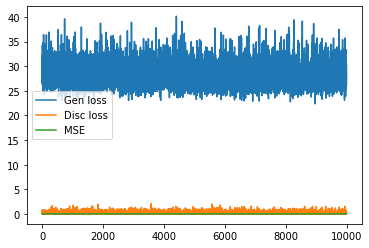

epoch: 69 	 step:0 	 loss: 31.36
epoch: 69 	 step:100 	 loss: 29.7
epoch: 69 	 step:200 	 loss: 27.0
epoch: 69 	 step:300 	 loss: 26.14
epoch: 69 	 step:400 	 loss: 31.16
epoch: 69 	 step:500 	 loss: 27.9
epoch: 69 	 step:600 	 loss: 32.63
epoch: 69 	 step:700 	 loss: 27.61
epoch: 69 	 step:800 	 loss: 27.36
epoch: 69 	 step:900 	 loss: 32.8
epoch: 69 	 step:1000 	 loss: 27.42
epoch: 69 	 step:1100 	 loss: 31.53
epoch: 69 	 step:1200 	 loss: 31.81
epoch: 69 	 step:1300 	 loss: 28.81
epoch: 69 	 step:1400 	 loss: 31.6
epoch: 69 	 step:1500 	 loss: 28.37
epoch: 69 	 step:1600 	 loss: 28.44
epoch: 69 	 step:1700 	 loss: 28.3
epoch: 69 	 step:1800 	 loss: 27.88


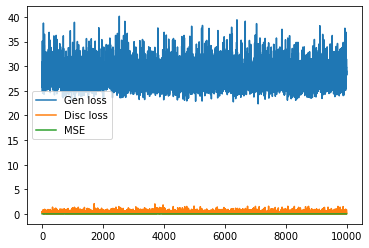

epoch: 70 	 step:0 	 loss: 26.81
epoch: 70 	 step:100 	 loss: 27.48
epoch: 70 	 step:200 	 loss: 27.51
epoch: 70 	 step:300 	 loss: 28.62
epoch: 70 	 step:400 	 loss: 24.82
epoch: 70 	 step:500 	 loss: 31.99
epoch: 70 	 step:600 	 loss: 25.14
epoch: 70 	 step:700 	 loss: 31.39
epoch: 70 	 step:800 	 loss: 27.68
epoch: 70 	 step:900 	 loss: 28.04
epoch: 70 	 step:1000 	 loss: 29.32
epoch: 70 	 step:1100 	 loss: 33.27
epoch: 70 	 step:1200 	 loss: 30.66
epoch: 70 	 step:1300 	 loss: 31.67
epoch: 70 	 step:1400 	 loss: 27.5
epoch: 70 	 step:1500 	 loss: 31.99
epoch: 70 	 step:1600 	 loss: 29.55
epoch: 70 	 step:1700 	 loss: 28.25
epoch: 70 	 step:1800 	 loss: 27.04


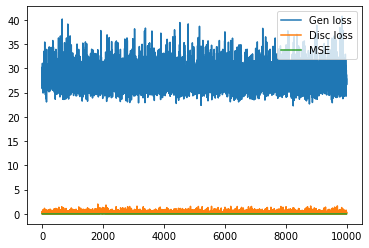

epoch: 71 	 step:0 	 loss: 28.7
epoch: 71 	 step:100 	 loss: 23.81
epoch: 71 	 step:200 	 loss: 28.45
epoch: 71 	 step:300 	 loss: 25.94
epoch: 71 	 step:400 	 loss: 27.23
epoch: 71 	 step:500 	 loss: 29.03
epoch: 71 	 step:600 	 loss: 29.11
epoch: 71 	 step:700 	 loss: 25.75
epoch: 71 	 step:800 	 loss: 27.75
epoch: 71 	 step:900 	 loss: 25.88
epoch: 71 	 step:1000 	 loss: 29.34
epoch: 71 	 step:1100 	 loss: 28.65
epoch: 71 	 step:1200 	 loss: 27.31
epoch: 71 	 step:1300 	 loss: 30.62
epoch: 71 	 step:1400 	 loss: 30.52
epoch: 71 	 step:1500 	 loss: 27.02
epoch: 71 	 step:1600 	 loss: 24.68
epoch: 71 	 step:1700 	 loss: 29.82
epoch: 71 	 step:1800 	 loss: 27.05


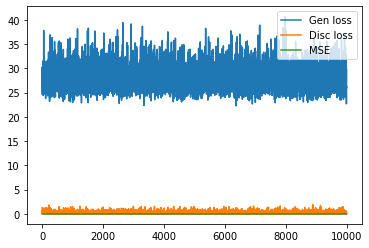

epoch: 72 	 step:0 	 loss: 27.77
epoch: 72 	 step:100 	 loss: 29.78
epoch: 72 	 step:200 	 loss: 28.53
epoch: 72 	 step:300 	 loss: 32.23
epoch: 72 	 step:400 	 loss: 26.25
epoch: 72 	 step:500 	 loss: 27.53
epoch: 72 	 step:600 	 loss: 28.13
epoch: 72 	 step:700 	 loss: 27.84
epoch: 72 	 step:800 	 loss: 25.26
epoch: 72 	 step:900 	 loss: 28.24
epoch: 72 	 step:1000 	 loss: 26.04
epoch: 72 	 step:1100 	 loss: 30.44
epoch: 72 	 step:1200 	 loss: 24.62
epoch: 72 	 step:1300 	 loss: 26.1
epoch: 72 	 step:1400 	 loss: 29.53
epoch: 72 	 step:1500 	 loss: 26.44
epoch: 72 	 step:1600 	 loss: 26.06
epoch: 72 	 step:1700 	 loss: 27.0
epoch: 72 	 step:1800 	 loss: 25.94


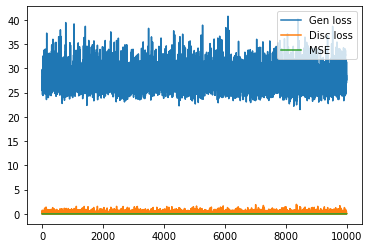

epoch: 73 	 step:0 	 loss: 23.74
epoch: 73 	 step:100 	 loss: 24.74
epoch: 73 	 step:200 	 loss: 29.76
epoch: 73 	 step:300 	 loss: 27.01
epoch: 73 	 step:400 	 loss: 32.68
epoch: 73 	 step:500 	 loss: 25.4
epoch: 73 	 step:600 	 loss: 29.26
epoch: 73 	 step:700 	 loss: 27.47
epoch: 73 	 step:800 	 loss: 26.99
epoch: 73 	 step:900 	 loss: 24.92
epoch: 73 	 step:1000 	 loss: 26.07
epoch: 73 	 step:1100 	 loss: 31.2
epoch: 73 	 step:1200 	 loss: 25.52
epoch: 73 	 step:1300 	 loss: 26.5
epoch: 73 	 step:1400 	 loss: 26.0
epoch: 73 	 step:1500 	 loss: 26.76
epoch: 73 	 step:1600 	 loss: 24.56
epoch: 73 	 step:1700 	 loss: 28.67
epoch: 73 	 step:1800 	 loss: 27.11


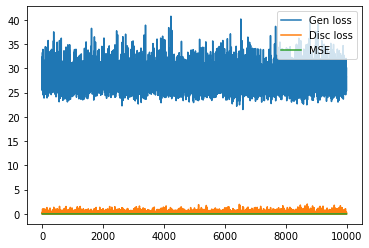

epoch: 74 	 step:0 	 loss: 26.71
epoch: 74 	 step:100 	 loss: 28.21
epoch: 74 	 step:200 	 loss: 25.99
epoch: 74 	 step:300 	 loss: 26.0
epoch: 74 	 step:400 	 loss: 28.39
epoch: 74 	 step:500 	 loss: 29.2
epoch: 74 	 step:600 	 loss: 25.83
epoch: 74 	 step:700 	 loss: 29.84
epoch: 74 	 step:800 	 loss: 26.38
epoch: 74 	 step:900 	 loss: 28.08
epoch: 74 	 step:1000 	 loss: 27.81
epoch: 74 	 step:1100 	 loss: 25.4
epoch: 74 	 step:1200 	 loss: 26.01
epoch: 74 	 step:1300 	 loss: 26.41
epoch: 74 	 step:1400 	 loss: 24.57
epoch: 74 	 step:1500 	 loss: 27.47
epoch: 74 	 step:1600 	 loss: 29.12
epoch: 74 	 step:1700 	 loss: 27.06
epoch: 74 	 step:1800 	 loss: 27.11


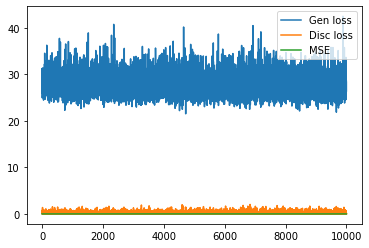

epoch: 75 	 step:0 	 loss: 25.58
epoch: 75 	 step:100 	 loss: 30.45
epoch: 75 	 step:200 	 loss: 25.41
epoch: 75 	 step:300 	 loss: 26.69
epoch: 75 	 step:400 	 loss: 23.93
epoch: 75 	 step:500 	 loss: 26.06
epoch: 75 	 step:600 	 loss: 25.95
epoch: 75 	 step:700 	 loss: 25.85
epoch: 75 	 step:800 	 loss: 25.42
epoch: 75 	 step:900 	 loss: 26.35
epoch: 75 	 step:1000 	 loss: 27.92
epoch: 75 	 step:1100 	 loss: 24.12
epoch: 75 	 step:1200 	 loss: 25.31
epoch: 75 	 step:1300 	 loss: 27.89
epoch: 75 	 step:1400 	 loss: 30.15
epoch: 75 	 step:1500 	 loss: 27.87
epoch: 75 	 step:1600 	 loss: 25.72
epoch: 75 	 step:1700 	 loss: 28.06
epoch: 75 	 step:1800 	 loss: 25.0


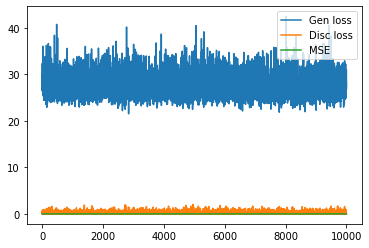

epoch: 76 	 step:0 	 loss: 25.42
epoch: 76 	 step:100 	 loss: 29.73
epoch: 76 	 step:200 	 loss: 27.49
epoch: 76 	 step:300 	 loss: 29.05
epoch: 76 	 step:400 	 loss: 24.19
epoch: 76 	 step:500 	 loss: 29.99
epoch: 76 	 step:600 	 loss: 31.24
epoch: 76 	 step:700 	 loss: 29.24
epoch: 76 	 step:800 	 loss: 23.65
epoch: 76 	 step:900 	 loss: 27.63
epoch: 76 	 step:1000 	 loss: 30.46
epoch: 76 	 step:1100 	 loss: 26.54
epoch: 76 	 step:1200 	 loss: 30.91
epoch: 76 	 step:1300 	 loss: 30.91
epoch: 76 	 step:1400 	 loss: 27.13
epoch: 76 	 step:1500 	 loss: 27.86
epoch: 76 	 step:1600 	 loss: 28.52
epoch: 76 	 step:1700 	 loss: 26.57
epoch: 76 	 step:1800 	 loss: 25.54


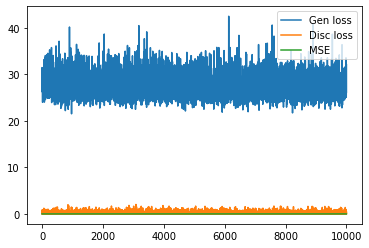

epoch: 77 	 step:0 	 loss: 26.1
epoch: 77 	 step:100 	 loss: 27.48
epoch: 77 	 step:200 	 loss: 26.26
epoch: 77 	 step:300 	 loss: 25.57
epoch: 77 	 step:400 	 loss: 22.93
epoch: 77 	 step:500 	 loss: 25.82
epoch: 77 	 step:600 	 loss: 24.07
epoch: 77 	 step:700 	 loss: 28.32
epoch: 77 	 step:800 	 loss: 27.14
epoch: 77 	 step:900 	 loss: 26.82
epoch: 77 	 step:1000 	 loss: 26.94
epoch: 77 	 step:1100 	 loss: 28.25
epoch: 77 	 step:1200 	 loss: 25.79
epoch: 77 	 step:1300 	 loss: 28.19
epoch: 77 	 step:1400 	 loss: 33.18
epoch: 77 	 step:1500 	 loss: 26.83
epoch: 77 	 step:1600 	 loss: 26.17
epoch: 77 	 step:1700 	 loss: 28.44
epoch: 77 	 step:1800 	 loss: 25.32


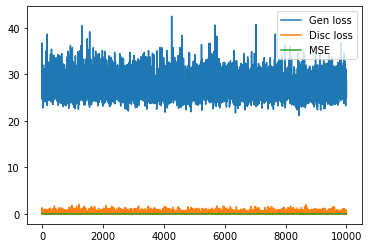

epoch: 78 	 step:0 	 loss: 25.06
epoch: 78 	 step:100 	 loss: 26.52
epoch: 78 	 step:200 	 loss: 22.86
epoch: 78 	 step:300 	 loss: 26.7
epoch: 78 	 step:400 	 loss: 28.21
epoch: 78 	 step:500 	 loss: 32.02
epoch: 78 	 step:600 	 loss: 25.59
epoch: 78 	 step:700 	 loss: 29.13
epoch: 78 	 step:800 	 loss: 24.71
epoch: 78 	 step:900 	 loss: 23.32
epoch: 78 	 step:1000 	 loss: 26.03
epoch: 78 	 step:1100 	 loss: 31.78
epoch: 78 	 step:1200 	 loss: 25.9
epoch: 78 	 step:1300 	 loss: 27.47
epoch: 78 	 step:1400 	 loss: 24.97
epoch: 78 	 step:1500 	 loss: 27.33
epoch: 78 	 step:1600 	 loss: 25.02
epoch: 78 	 step:1700 	 loss: 30.34
epoch: 78 	 step:1800 	 loss: 28.21


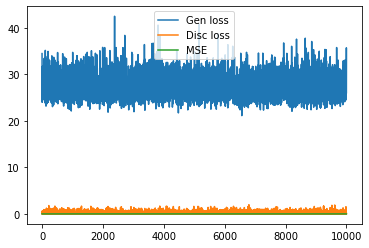

epoch: 79 	 step:0 	 loss: 26.69
epoch: 79 	 step:100 	 loss: 26.25
epoch: 79 	 step:200 	 loss: 22.79
epoch: 79 	 step:300 	 loss: 28.26
epoch: 79 	 step:400 	 loss: 25.99
epoch: 79 	 step:500 	 loss: 28.03
epoch: 79 	 step:600 	 loss: 27.44
epoch: 79 	 step:700 	 loss: 26.05
epoch: 79 	 step:800 	 loss: 26.63
epoch: 79 	 step:900 	 loss: 26.66
epoch: 79 	 step:1000 	 loss: 26.63
epoch: 79 	 step:1100 	 loss: 24.37
epoch: 79 	 step:1200 	 loss: 25.51
epoch: 79 	 step:1300 	 loss: 26.52
epoch: 79 	 step:1400 	 loss: 26.32
epoch: 79 	 step:1500 	 loss: 29.48
epoch: 79 	 step:1600 	 loss: 25.85
epoch: 79 	 step:1700 	 loss: 27.98
epoch: 79 	 step:1800 	 loss: 30.43


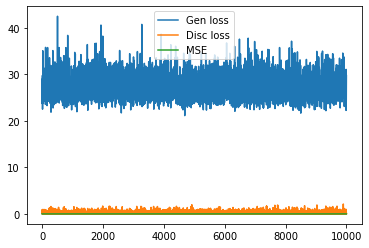

epoch: 80 	 step:0 	 loss: 25.83
epoch: 80 	 step:100 	 loss: 32.1
epoch: 80 	 step:200 	 loss: 24.44
epoch: 80 	 step:300 	 loss: 26.8
epoch: 80 	 step:400 	 loss: 25.17
epoch: 80 	 step:500 	 loss: 22.8
epoch: 80 	 step:600 	 loss: 24.9
epoch: 80 	 step:700 	 loss: 28.87
epoch: 80 	 step:800 	 loss: 28.88
epoch: 80 	 step:900 	 loss: 23.24
epoch: 80 	 step:1000 	 loss: 29.56
epoch: 80 	 step:1100 	 loss: 34.18
epoch: 80 	 step:1200 	 loss: 28.99
epoch: 80 	 step:1300 	 loss: 25.51
epoch: 80 	 step:1400 	 loss: 27.95
epoch: 80 	 step:1500 	 loss: 25.52
epoch: 80 	 step:1600 	 loss: 26.39
epoch: 80 	 step:1700 	 loss: 32.06
epoch: 80 	 step:1800 	 loss: 28.35


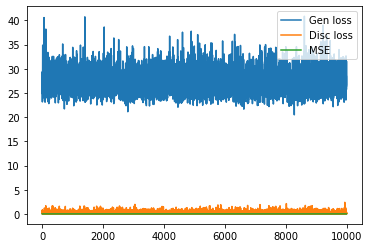

epoch: 81 	 step:0 	 loss: 31.12
epoch: 81 	 step:100 	 loss: 25.76
epoch: 81 	 step:200 	 loss: 25.54
epoch: 81 	 step:300 	 loss: 24.06
epoch: 81 	 step:400 	 loss: 25.62
epoch: 81 	 step:500 	 loss: 28.2
epoch: 81 	 step:600 	 loss: 29.44
epoch: 81 	 step:700 	 loss: 29.3
epoch: 81 	 step:800 	 loss: 26.13
epoch: 81 	 step:900 	 loss: 28.61
epoch: 81 	 step:1000 	 loss: 24.62
epoch: 81 	 step:1100 	 loss: 29.2
epoch: 81 	 step:1200 	 loss: 28.16
epoch: 81 	 step:1300 	 loss: 26.02
epoch: 81 	 step:1400 	 loss: 28.91
epoch: 81 	 step:1500 	 loss: 22.85
epoch: 81 	 step:1600 	 loss: 26.07
epoch: 81 	 step:1700 	 loss: 24.2
epoch: 81 	 step:1800 	 loss: 30.92


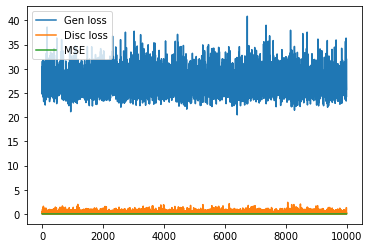

epoch: 82 	 step:0 	 loss: 25.53
epoch: 82 	 step:100 	 loss: 25.63
epoch: 82 	 step:200 	 loss: 29.11
epoch: 82 	 step:300 	 loss: 27.71
epoch: 82 	 step:400 	 loss: 25.58
epoch: 82 	 step:500 	 loss: 27.05
epoch: 82 	 step:600 	 loss: 27.62
epoch: 82 	 step:700 	 loss: 32.66
epoch: 82 	 step:800 	 loss: 26.46
epoch: 82 	 step:900 	 loss: 30.54
epoch: 82 	 step:1000 	 loss: 25.95
epoch: 82 	 step:1100 	 loss: 26.03
epoch: 82 	 step:1200 	 loss: 26.98
epoch: 82 	 step:1300 	 loss: 26.23
epoch: 82 	 step:1400 	 loss: 25.68
epoch: 82 	 step:1500 	 loss: 27.04
epoch: 82 	 step:1600 	 loss: 26.28
epoch: 82 	 step:1700 	 loss: 26.51
epoch: 82 	 step:1800 	 loss: 28.08


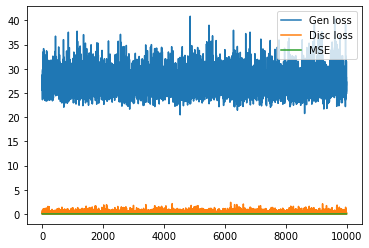

epoch: 83 	 step:0 	 loss: 29.08
epoch: 83 	 step:100 	 loss: 27.19
epoch: 83 	 step:200 	 loss: 24.26
epoch: 83 	 step:300 	 loss: 24.53
epoch: 83 	 step:400 	 loss: 26.24
epoch: 83 	 step:500 	 loss: 30.26
epoch: 83 	 step:600 	 loss: 26.91
epoch: 83 	 step:700 	 loss: 25.72
epoch: 83 	 step:800 	 loss: 27.15
epoch: 83 	 step:900 	 loss: 26.65
epoch: 83 	 step:1000 	 loss: 25.01
epoch: 83 	 step:1100 	 loss: 28.02
epoch: 83 	 step:1200 	 loss: 25.0
epoch: 83 	 step:1300 	 loss: 24.07
epoch: 83 	 step:1400 	 loss: 25.31
epoch: 83 	 step:1500 	 loss: 33.01
epoch: 83 	 step:1600 	 loss: 26.75
epoch: 83 	 step:1700 	 loss: 28.41
epoch: 83 	 step:1800 	 loss: 27.16


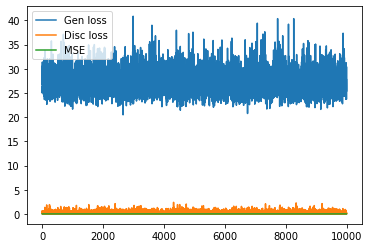

epoch: 84 	 step:0 	 loss: 27.2
epoch: 84 	 step:100 	 loss: 23.46
epoch: 84 	 step:200 	 loss: 27.03
epoch: 84 	 step:300 	 loss: 25.91
epoch: 84 	 step:400 	 loss: 30.21
epoch: 84 	 step:500 	 loss: 26.91
epoch: 84 	 step:600 	 loss: 31.83
epoch: 84 	 step:700 	 loss: 25.34
epoch: 84 	 step:800 	 loss: 24.26
epoch: 84 	 step:900 	 loss: 32.06
epoch: 84 	 step:1000 	 loss: 26.41
epoch: 84 	 step:1100 	 loss: 23.69
epoch: 84 	 step:1200 	 loss: 27.82
epoch: 84 	 step:1300 	 loss: 27.81
epoch: 84 	 step:1400 	 loss: 29.26
epoch: 84 	 step:1500 	 loss: 27.1
epoch: 84 	 step:1600 	 loss: 25.14
epoch: 84 	 step:1700 	 loss: 28.03
epoch: 84 	 step:1800 	 loss: 28.0


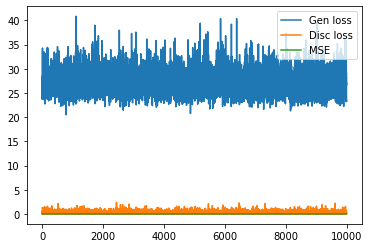

epoch: 85 	 step:0 	 loss: 23.34
epoch: 85 	 step:100 	 loss: 32.82
epoch: 85 	 step:200 	 loss: 26.14
epoch: 85 	 step:300 	 loss: 27.94
epoch: 85 	 step:400 	 loss: 28.4
epoch: 85 	 step:500 	 loss: 26.6
epoch: 85 	 step:600 	 loss: 28.01
epoch: 85 	 step:700 	 loss: 25.04
epoch: 85 	 step:800 	 loss: 25.81
epoch: 85 	 step:900 	 loss: 25.48
epoch: 85 	 step:1000 	 loss: 29.99
epoch: 85 	 step:1100 	 loss: 24.48
epoch: 85 	 step:1200 	 loss: 31.12
epoch: 85 	 step:1300 	 loss: 26.58
epoch: 85 	 step:1400 	 loss: 26.13
epoch: 85 	 step:1500 	 loss: 28.9
epoch: 85 	 step:1600 	 loss: 29.74
epoch: 85 	 step:1700 	 loss: 28.57
epoch: 85 	 step:1800 	 loss: 26.35


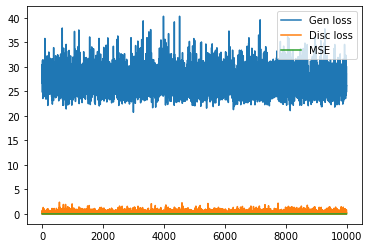

epoch: 86 	 step:0 	 loss: 24.28
epoch: 86 	 step:100 	 loss: 25.56
epoch: 86 	 step:200 	 loss: 26.89
epoch: 86 	 step:300 	 loss: 24.5
epoch: 86 	 step:400 	 loss: 26.24
epoch: 86 	 step:500 	 loss: 25.18
epoch: 86 	 step:600 	 loss: 26.53
epoch: 86 	 step:700 	 loss: 28.86
epoch: 86 	 step:800 	 loss: 24.63
epoch: 86 	 step:900 	 loss: 25.58
epoch: 86 	 step:1000 	 loss: 28.2
epoch: 86 	 step:1100 	 loss: 30.46
epoch: 86 	 step:1200 	 loss: 24.28
epoch: 86 	 step:1300 	 loss: 25.21
epoch: 86 	 step:1400 	 loss: 26.46
epoch: 86 	 step:1500 	 loss: 30.51
epoch: 86 	 step:1600 	 loss: 23.77
epoch: 86 	 step:1700 	 loss: 32.15
epoch: 86 	 step:1800 	 loss: 29.96


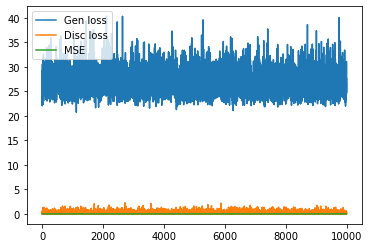

epoch: 87 	 step:0 	 loss: 24.47
epoch: 87 	 step:100 	 loss: 27.08
epoch: 87 	 step:200 	 loss: 25.05
epoch: 87 	 step:300 	 loss: 24.26
epoch: 87 	 step:400 	 loss: 27.75
epoch: 87 	 step:500 	 loss: 23.07
epoch: 87 	 step:600 	 loss: 25.51
epoch: 87 	 step:700 	 loss: 26.3
epoch: 87 	 step:800 	 loss: 29.47
epoch: 87 	 step:900 	 loss: 26.36
epoch: 87 	 step:1000 	 loss: 25.58
epoch: 87 	 step:1100 	 loss: 24.64
epoch: 87 	 step:1200 	 loss: 24.07
epoch: 87 	 step:1300 	 loss: 23.72
epoch: 87 	 step:1400 	 loss: 25.62
epoch: 87 	 step:1500 	 loss: 29.66
epoch: 87 	 step:1600 	 loss: 26.12
epoch: 87 	 step:1700 	 loss: 26.39
epoch: 87 	 step:1800 	 loss: 24.91


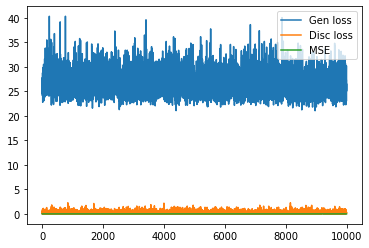

epoch: 88 	 step:0 	 loss: 25.09
epoch: 88 	 step:100 	 loss: 26.15
epoch: 88 	 step:200 	 loss: 24.68
epoch: 88 	 step:300 	 loss: 28.71
epoch: 88 	 step:400 	 loss: 25.0
epoch: 88 	 step:500 	 loss: 24.12
epoch: 88 	 step:600 	 loss: 26.94
epoch: 88 	 step:700 	 loss: 24.85
epoch: 88 	 step:800 	 loss: 32.95
epoch: 88 	 step:900 	 loss: 23.85
epoch: 88 	 step:1000 	 loss: 26.65
epoch: 88 	 step:1100 	 loss: 27.62
epoch: 88 	 step:1200 	 loss: 25.37
epoch: 88 	 step:1300 	 loss: 25.46
epoch: 88 	 step:1400 	 loss: 28.95
epoch: 88 	 step:1500 	 loss: 26.0
epoch: 88 	 step:1600 	 loss: 25.02
epoch: 88 	 step:1700 	 loss: 25.71
epoch: 88 	 step:1800 	 loss: 24.05


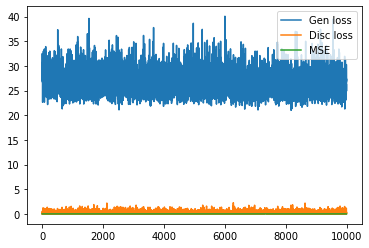

epoch: 89 	 step:0 	 loss: 27.43
epoch: 89 	 step:100 	 loss: 30.91
epoch: 89 	 step:200 	 loss: 24.22
epoch: 89 	 step:300 	 loss: 22.96
epoch: 89 	 step:400 	 loss: 25.25
epoch: 89 	 step:500 	 loss: 24.97
epoch: 89 	 step:600 	 loss: 26.01
epoch: 89 	 step:700 	 loss: 25.12
epoch: 89 	 step:800 	 loss: 27.75
epoch: 89 	 step:900 	 loss: 26.55
epoch: 89 	 step:1000 	 loss: 25.11
epoch: 89 	 step:1100 	 loss: 26.06
epoch: 89 	 step:1200 	 loss: 25.41
epoch: 89 	 step:1300 	 loss: 26.17
epoch: 89 	 step:1400 	 loss: 25.04
epoch: 89 	 step:1500 	 loss: 23.63
epoch: 89 	 step:1600 	 loss: 25.19
epoch: 89 	 step:1700 	 loss: 27.95
epoch: 89 	 step:1800 	 loss: 25.21


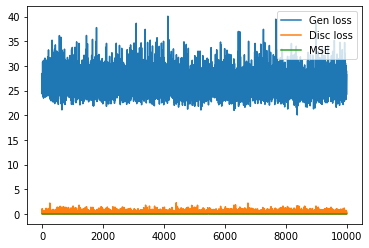

epoch: 90 	 step:0 	 loss: 24.92
epoch: 90 	 step:100 	 loss: 27.97
epoch: 90 	 step:200 	 loss: 24.33
epoch: 90 	 step:300 	 loss: 23.53
epoch: 90 	 step:400 	 loss: 26.49
epoch: 90 	 step:500 	 loss: 24.29
epoch: 90 	 step:600 	 loss: 27.18
epoch: 90 	 step:700 	 loss: 27.28
epoch: 90 	 step:800 	 loss: 23.63
epoch: 90 	 step:900 	 loss: 28.74
epoch: 90 	 step:1000 	 loss: 29.06
epoch: 90 	 step:1100 	 loss: 25.22
epoch: 90 	 step:1200 	 loss: 27.63
epoch: 90 	 step:1300 	 loss: 27.7
epoch: 90 	 step:1400 	 loss: 24.7
epoch: 90 	 step:1500 	 loss: 25.67
epoch: 90 	 step:1600 	 loss: 25.68
epoch: 90 	 step:1700 	 loss: 22.51
epoch: 90 	 step:1800 	 loss: 22.55


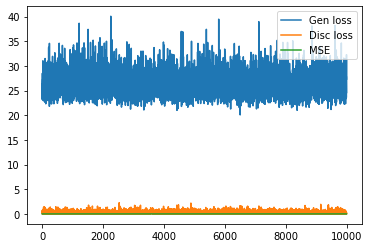

epoch: 91 	 step:0 	 loss: 25.96
epoch: 91 	 step:100 	 loss: 26.32
epoch: 91 	 step:200 	 loss: 24.82
epoch: 91 	 step:300 	 loss: 25.48
epoch: 91 	 step:400 	 loss: 25.16
epoch: 91 	 step:500 	 loss: 28.1
epoch: 91 	 step:600 	 loss: 24.54
epoch: 91 	 step:700 	 loss: 23.69
epoch: 91 	 step:800 	 loss: 29.9
epoch: 91 	 step:900 	 loss: 26.78
epoch: 91 	 step:1000 	 loss: 28.04
epoch: 91 	 step:1100 	 loss: 26.78
epoch: 91 	 step:1200 	 loss: 24.61
epoch: 91 	 step:1300 	 loss: 24.42
epoch: 91 	 step:1400 	 loss: 22.92
epoch: 91 	 step:1500 	 loss: 26.2
epoch: 91 	 step:1600 	 loss: 26.53
epoch: 91 	 step:1700 	 loss: 28.34
epoch: 91 	 step:1800 	 loss: 29.73


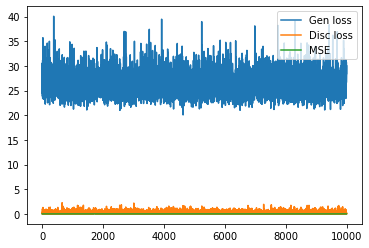

epoch: 92 	 step:0 	 loss: 25.87
epoch: 92 	 step:100 	 loss: 25.04
epoch: 92 	 step:200 	 loss: 27.28
epoch: 92 	 step:300 	 loss: 26.07
epoch: 92 	 step:400 	 loss: 24.2
epoch: 92 	 step:500 	 loss: 25.65
epoch: 92 	 step:600 	 loss: 26.08
epoch: 92 	 step:700 	 loss: 26.22
epoch: 92 	 step:800 	 loss: 26.74
epoch: 92 	 step:900 	 loss: 26.97
epoch: 92 	 step:1000 	 loss: 26.69
epoch: 92 	 step:1100 	 loss: 27.23
epoch: 92 	 step:1200 	 loss: 24.28
epoch: 92 	 step:1300 	 loss: 26.71
epoch: 92 	 step:1400 	 loss: 25.96
epoch: 92 	 step:1500 	 loss: 26.67
epoch: 92 	 step:1600 	 loss: 26.72
epoch: 92 	 step:1700 	 loss: 22.24
epoch: 92 	 step:1800 	 loss: 26.73


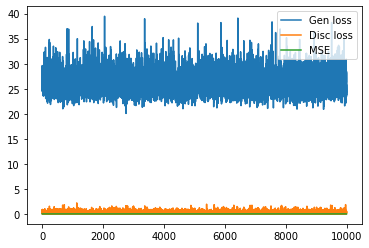

epoch: 93 	 step:0 	 loss: 26.28
epoch: 93 	 step:100 	 loss: 23.04
epoch: 93 	 step:200 	 loss: 22.12
epoch: 93 	 step:300 	 loss: 32.28
epoch: 93 	 step:400 	 loss: 21.32
epoch: 93 	 step:500 	 loss: 26.32
epoch: 93 	 step:600 	 loss: 23.02
epoch: 93 	 step:700 	 loss: 26.98
epoch: 93 	 step:800 	 loss: 26.68
epoch: 93 	 step:900 	 loss: 25.24
epoch: 93 	 step:1000 	 loss: 27.29
epoch: 93 	 step:1100 	 loss: 25.92
epoch: 93 	 step:1200 	 loss: 26.39
epoch: 93 	 step:1300 	 loss: 24.94
epoch: 93 	 step:1400 	 loss: 23.88
epoch: 93 	 step:1500 	 loss: 23.47
epoch: 93 	 step:1600 	 loss: 25.67
epoch: 93 	 step:1700 	 loss: 22.04
epoch: 93 	 step:1800 	 loss: 28.6


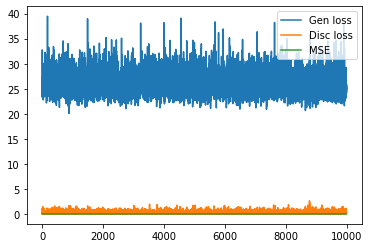

epoch: 94 	 step:0 	 loss: 23.27
epoch: 94 	 step:100 	 loss: 25.88
epoch: 94 	 step:200 	 loss: 25.27
epoch: 94 	 step:300 	 loss: 24.33
epoch: 94 	 step:400 	 loss: 23.98
epoch: 94 	 step:500 	 loss: 25.92
epoch: 94 	 step:600 	 loss: 23.08
epoch: 94 	 step:700 	 loss: 24.93
epoch: 94 	 step:800 	 loss: 27.54
epoch: 94 	 step:900 	 loss: 25.53
epoch: 94 	 step:1000 	 loss: 25.09
epoch: 94 	 step:1100 	 loss: 22.5
epoch: 94 	 step:1200 	 loss: 23.88
epoch: 94 	 step:1300 	 loss: 25.85
epoch: 94 	 step:1400 	 loss: 25.39
epoch: 94 	 step:1500 	 loss: 27.55
epoch: 94 	 step:1600 	 loss: 25.27
epoch: 94 	 step:1700 	 loss: 24.43
epoch: 94 	 step:1800 	 loss: 24.59


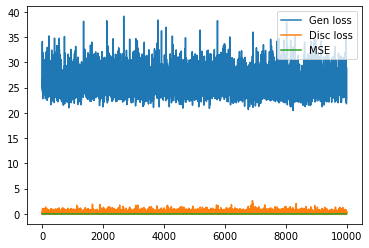

epoch: 95 	 step:0 	 loss: 24.71
epoch: 95 	 step:100 	 loss: 24.22
epoch: 95 	 step:200 	 loss: 24.72
epoch: 95 	 step:300 	 loss: 25.09
epoch: 95 	 step:400 	 loss: 25.19
epoch: 95 	 step:500 	 loss: 24.96
epoch: 95 	 step:600 	 loss: 25.56
epoch: 95 	 step:700 	 loss: 25.22
epoch: 95 	 step:800 	 loss: 24.76
epoch: 95 	 step:900 	 loss: 27.52
epoch: 95 	 step:1000 	 loss: 29.42
epoch: 95 	 step:1100 	 loss: 24.33
epoch: 95 	 step:1200 	 loss: 27.58
epoch: 95 	 step:1300 	 loss: 23.74
epoch: 95 	 step:1400 	 loss: 26.52
epoch: 95 	 step:1500 	 loss: 27.32
epoch: 95 	 step:1600 	 loss: 26.01
epoch: 95 	 step:1700 	 loss: 23.01
epoch: 95 	 step:1800 	 loss: 25.21


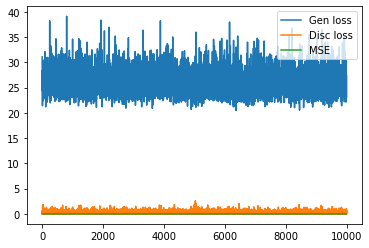

epoch: 96 	 step:0 	 loss: 24.28
epoch: 96 	 step:100 	 loss: 23.8
epoch: 96 	 step:200 	 loss: 26.18
epoch: 96 	 step:300 	 loss: 22.46
epoch: 96 	 step:400 	 loss: 24.93
epoch: 96 	 step:500 	 loss: 24.73
epoch: 96 	 step:600 	 loss: 25.57
epoch: 96 	 step:700 	 loss: 22.22
epoch: 96 	 step:800 	 loss: 25.13
epoch: 96 	 step:900 	 loss: 24.81
epoch: 96 	 step:1000 	 loss: 27.05
epoch: 96 	 step:1100 	 loss: 26.43
epoch: 96 	 step:1200 	 loss: 22.22
epoch: 96 	 step:1300 	 loss: 25.26
epoch: 96 	 step:1400 	 loss: 26.38
epoch: 96 	 step:1500 	 loss: 28.36
epoch: 96 	 step:1600 	 loss: 25.19
epoch: 96 	 step:1700 	 loss: 22.6
epoch: 96 	 step:1800 	 loss: 29.05


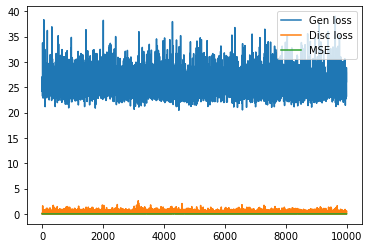

epoch: 97 	 step:0 	 loss: 23.98
epoch: 97 	 step:100 	 loss: 26.82
epoch: 97 	 step:200 	 loss: 24.73
epoch: 97 	 step:300 	 loss: 25.67
epoch: 97 	 step:400 	 loss: 22.73
epoch: 97 	 step:500 	 loss: 25.1
epoch: 97 	 step:600 	 loss: 25.08
epoch: 97 	 step:700 	 loss: 22.34
epoch: 97 	 step:800 	 loss: 26.44
epoch: 97 	 step:900 	 loss: 25.61
epoch: 97 	 step:1000 	 loss: 24.13
epoch: 97 	 step:1100 	 loss: 24.66
epoch: 97 	 step:1200 	 loss: 28.41
epoch: 97 	 step:1300 	 loss: 24.76
epoch: 97 	 step:1400 	 loss: 26.74
epoch: 97 	 step:1500 	 loss: 27.48
epoch: 97 	 step:1600 	 loss: 22.7
epoch: 97 	 step:1700 	 loss: 25.5
epoch: 97 	 step:1800 	 loss: 25.83


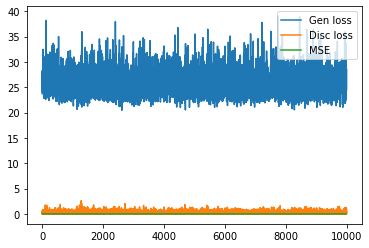

epoch: 98 	 step:0 	 loss: 23.43
epoch: 98 	 step:100 	 loss: 25.05
epoch: 98 	 step:200 	 loss: 23.88
epoch: 98 	 step:300 	 loss: 29.92
epoch: 98 	 step:400 	 loss: 25.96
epoch: 98 	 step:500 	 loss: 31.67
epoch: 98 	 step:600 	 loss: 26.03
epoch: 98 	 step:700 	 loss: 27.63
epoch: 98 	 step:800 	 loss: 23.55
epoch: 98 	 step:900 	 loss: 28.55
epoch: 98 	 step:1000 	 loss: 26.43
epoch: 98 	 step:1100 	 loss: 24.38
epoch: 98 	 step:1200 	 loss: 23.12
epoch: 98 	 step:1300 	 loss: 22.43
epoch: 98 	 step:1400 	 loss: 28.04
epoch: 98 	 step:1500 	 loss: 24.6
epoch: 98 	 step:1600 	 loss: 23.6
epoch: 98 	 step:1700 	 loss: 31.5
epoch: 98 	 step:1800 	 loss: 25.24


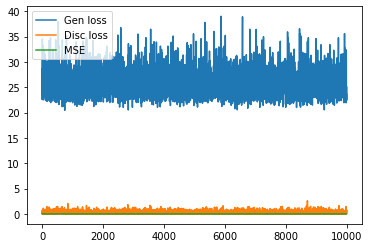

epoch: 99 	 step:0 	 loss: 23.55
epoch: 99 	 step:100 	 loss: 25.21
epoch: 99 	 step:200 	 loss: 22.86
epoch: 99 	 step:300 	 loss: 29.67
epoch: 99 	 step:400 	 loss: 22.76
epoch: 99 	 step:500 	 loss: 25.14
epoch: 99 	 step:600 	 loss: 26.32
epoch: 99 	 step:700 	 loss: 25.34
epoch: 99 	 step:800 	 loss: 26.15
epoch: 99 	 step:900 	 loss: 24.84
epoch: 99 	 step:1000 	 loss: 30.03
epoch: 99 	 step:1100 	 loss: 29.77
epoch: 99 	 step:1200 	 loss: 28.12
epoch: 99 	 step:1300 	 loss: 21.9
epoch: 99 	 step:1400 	 loss: 24.65
epoch: 99 	 step:1500 	 loss: 25.61
epoch: 99 	 step:1600 	 loss: 23.66
epoch: 99 	 step:1700 	 loss: 32.02
epoch: 99 	 step:1800 	 loss: 24.78


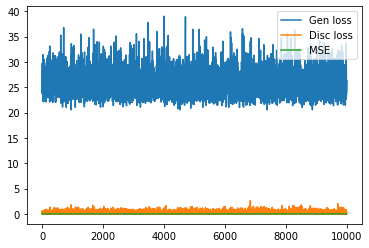

epoch: 100 	 step:0 	 loss: 24.35
epoch: 100 	 step:100 	 loss: 30.75
epoch: 100 	 step:200 	 loss: 25.15
epoch: 100 	 step:300 	 loss: 24.04
epoch: 100 	 step:400 	 loss: 25.03
epoch: 100 	 step:500 	 loss: 25.27
epoch: 100 	 step:600 	 loss: 26.78
epoch: 100 	 step:700 	 loss: 21.76
epoch: 100 	 step:800 	 loss: 26.34
epoch: 100 	 step:900 	 loss: 22.9
epoch: 100 	 step:1000 	 loss: 25.75
epoch: 100 	 step:1100 	 loss: 24.61
epoch: 100 	 step:1200 	 loss: 27.5
epoch: 100 	 step:1300 	 loss: 24.73
epoch: 100 	 step:1400 	 loss: 25.04
epoch: 100 	 step:1500 	 loss: 22.76
epoch: 100 	 step:1600 	 loss: 27.58
epoch: 100 	 step:1700 	 loss: 25.35
epoch: 100 	 step:1800 	 loss: 28.43


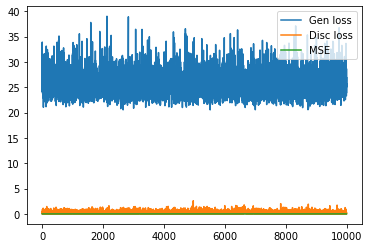

[0.23407688736915588,
 0.22675034403800964,
 0.22039343416690826,
 0.21169884502887726,
 0.20531447231769562,
 0.19743549823760986,
 0.19128082692623138,
 0.18390706181526184,
 0.17835451662540436,
 0.1722618043422699,
 0.1657218486070633,
 0.16024360060691833,
 0.15385223925113678,
 0.15121009945869446,
 0.14493128657341003,
 0.13958854973316193,
 0.13582250475883484,
 0.13089701533317566,
 0.1254758983850479,
 0.1211230605840683,
 0.11880971491336823,
 0.11221123486757278,
 0.11403945833444595,
 0.10984396934509277,
 0.10282472521066666,
 0.10004759579896927,
 0.09756533801555634,
 0.09561122953891754,
 0.09121355414390564,
 0.09096699953079224,
 0.08464250713586807,
 0.0847877785563469,
 0.08536329120397568,
 0.08156949281692505,
 0.0827651396393776,
 0.08187570422887802,
 0.07512708008289337,
 0.07629315555095673,
 0.07164526730775833,
 0.06919905543327332,
 0.07453662157058716,
 0.07246144115924835,
 0.0696481391787529,
 0.0755244567990303,
 0.07912518084049225,
 0.068494871258735

In [18]:
### TRAIN MODEL ###

import time
num_epochs = 100

train_model(gen, disc, g_opt, d_opt, device, dataloader['train'], epochs=num_epochs)

gen_weights = gen.state_dict().copy()
disc_weights = disc.state_dict().copy()

torch.save(gen_weights, "../cache/models/cGAN_MNIST/FCGenerator2048MNIST_{}.sd".format(model_name))
torch.save(disc_weights, "../cache/models/cGAN_MNIST/ConvDiscriminator64MNIST_{}.sd".format(model_name))

In [13]:
### LOAD MODEL ####

gen = models.FCNet(imsize=(2, 28, 28), outsize=imsize, h=2048)
#gen = models.ConvNet(imsize=(2, 28, 28), outsize=imsize, s=64)
#disc = models.FCDiscriminator(imsize=imsize, h=2048)
#disc = models.ConvDiscriminatorSmall(imsize=(2, 28, 28), s=64)

# TODO: map storage location to correct GPU!
gen.load_state_dict(torch.load("../cache/models/cGAN_MNIST/FCGenerator2048MNIST_{}.sd".format(model_name), map_location={'cuda:1': device.__str__()}));
#disc.load_state_dict(torch.load("../cache/models/cGAN_MNIST/ConvDiscriminator64MNIST_{}.sd".format(model_name), map_location={'cuda:1': device.__str__()}));

Version 0.4


In [19]:
def test_generator(model, device, testloader):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        data = data.to(device=device)
        magn = calc_mags(data)
        
        z = torch.randn(*data.shape).to(device)
        #z = torch.zeros(*data.shape).to(device)
        #z = magn.clone()
        
        net_input = torch.cat([z, magn], dim=1)
        ouput = model(net_input)

        test_images.append(data.cpu().numpy())
        outputs.append(ouput.cpu().detach().numpy())
    
    return np.concatenate(outputs), np.concatenate(test_images)

In [20]:
# Calculate test predictions #

test_predicted, test_original = test_generator(gen, device, dataloader['test'])
print(test_predicted.shape)

(8000, 1, 28, 28)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


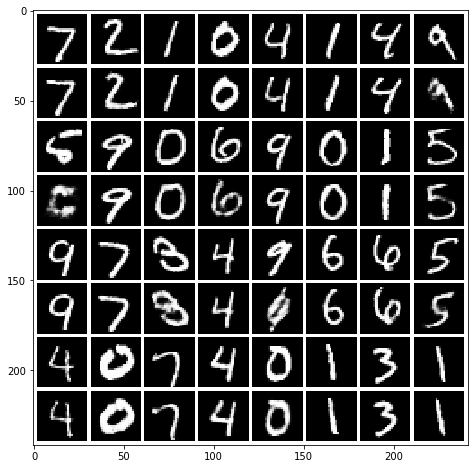

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Registered:


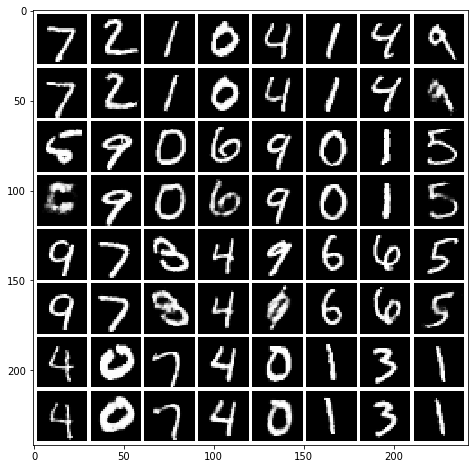

In [23]:
# Print test predictions 2 #
# Print predictions #
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    test_predicted[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8), file="../out/MNIST/end-to-end/signal-prediction/cgan-" + model_name + ".png")

print("Registered:")
results_reg = register_croco(test_predicted[:32], test_original[:32])
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8), file="../out/MNIST/end-to-end/signal-prediction/cgan-" + model_name + "-reg.png")

In [24]:
# Benchmark test predictions #

benchmark(pred=test_predicted[:1024], true=test_original[:1024], check_all=True)

Signal error:
  MSE: 0.02357058668440004, std: 0.018517652259413604
  MAE: 0.048347419855417684, std: 0.025209085424727513
  SSIM: 0.8004792447607187, std: 0.13616147547767352
  Sharpness: 0.09058855680093886, std: 0.029580816310751684
  PhCo-MSE: 0.019451595466762228, std: 0.013609217380385265
  PhCo-MAE: 0.04318176957713149, std: 0.019552106127082827
  PhCo-SSIM: 0.8267983475067924, std: 0.1073223846082602
  CroCo-MSE: 0.01700515545098824, std: 0.00995452510502966
  CroCo-MAE: 0.04018363075374509, std: 0.016631102131182816
  CroCo-SSIM: 0.8442413116595613, std: 0.08845702101708769

Magnitude error:
  MSE Magnitude: 3.72914874022833, std: 2.7209025433326675

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.02357 | 0.04835 | 0.8005 | 0.09059 | 0.01945 | 0.04318 | 0.8268 | 0.01701 | 0.04018 | 0.8442 | 3.729 |


In [1]:
2.7348702121192536 / 32

0.08546469412872668

## Evaluation for different cGAN models (random z and 1024 samples)

| Nr | Type | Loss | Size | epochs | MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| zeroz | z=0 |  log GAN + 1e3 * MAE | 2048 + 64 | 100 | 0.02380 | 0.04851 | 0.7977 | 0.09073 | 0.01921 | 0.04275 | 0.8292 | 0.01708 | 0.04018 | 0.8432 | 3.746 |
| zeqy | z=y |  log GAN + 1e3 * MAE | 2048 + 64 | 100 | 0.02369 | 0.04853 | 0.7991 | 0.09055 | 0.01923 | 0.04284 | 0.8286 | 0.01705 | 0.04023 | 0.8439 | 3.739 |
| randz | z=randn |  log GAN + 1e3 * MAE | 2048 + 64 | 100 | 0.02357 | 0.04835 | 0.8005 | 0.09059 | 0.01945 | 0.04318 | 0.8268 | 0.01701 | 0.04018 | 0.8442 | 3.729 |
| 4 | no z |  log GAN + 1e3 * MAE | 2048 + 64 | 100 |
| cnn-zeroz | z=0 |  log GAN + 1e3 * MAE | 64 + 64 | 100 | 0.02354 | 0.04738 | 0.8070 | 0.08989 | 0.01865 | 0.04124 | 0.8373 | 0.01657 | 0.03871 | 0.8520 | 3.451 |



---

Signal error:
  MSE: 0.023802218873470338, std: 0.018557068021213916
  MAE: 0.04850688956776139, std: 0.025166225426382145
  SSIM: 0.7977106147933677, std: 0.1373397344596359
  Sharpness: 0.09072605149022517, std: 0.029199043180410045
  PhCo-MSE: 0.01920988507799848, std: 0.013962708476435024
  PhCo-MAE: 0.04275337876788399, std: 0.019955339837471
  PhCo-SSIM: 0.8292217480620372, std: 0.10537465246167327
  CroCo-MSE: 0.017078609958161906, std: 0.009894290002713918
  CroCo-MAE: 0.04017762944476999, std: 0.016596378930219077
  CroCo-SSIM: 0.8432313636184955, std: 0.08766752107781194

Magnitude error:
  MSE Magnitude: 3.7456878685503527, std: 2.7348702121192536

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]
  
---

Signal error:
  MSE: 0.023691325136837804, std: 0.018638880306667393
  MAE: 0.04853277984329907, std: 0.02526385380316646
  SSIM: 0.7991016560140441, std: 0.1358400245129907
  Sharpness: 0.09054752884735487, std: 0.030497911496145957
  PhCo-MSE: 0.01923046668105144, std: 0.013891891743971277
  PhCo-MAE: 0.04284464444845071, std: 0.019894992871942924
  PhCo-SSIM: 0.828630358462725, std: 0.1084895597227173
  CroCo-MSE: 0.017048388330181297, std: 0.010059930309093253
  CroCo-MAE: 0.04023356342713669, std: 0.016729690898812297
  CroCo-SSIM: 0.8438978302954361, std: 0.08922126137265433

Magnitude error:
  MSE Magnitude: 3.7386980182129417, std: 2.705082915242373

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

---

Signal error:
  MSE: 0.02357058668440004, std: 0.018517652259413604
  MAE: 0.048347419855417684, std: 0.025209085424727513
  SSIM: 0.8004792447607187, std: 0.13616147547767352
  Sharpness: 0.09058855680093886, std: 0.029580816310751684
  PhCo-MSE: 0.019451595466762228, std: 0.013609217380385265
  PhCo-MAE: 0.04318176957713149, std: 0.019552106127082827
  PhCo-SSIM: 0.8267983475067924, std: 0.1073223846082602
  CroCo-MSE: 0.01700515545098824, std: 0.00995452510502966
  CroCo-MAE: 0.04018363075374509, std: 0.016631102131182816
  CroCo-SSIM: 0.8442413116595613, std: 0.08845702101708769

Magnitude error:
  MSE Magnitude: 3.72914874022833, std: 2.7209025433326675

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]